# Proyecto: DataGol

El propósito de este proyecto es categorizar a jugadores en base a su estilo de juego, independientemente de su rol, con la finalidad de encontrar una alineación que (dada una alineación del oponente) optimice la esperanza de goles a favor.
---

## Importación de librerías

In [115]:
!pip install mplsoccer
!pip install statsbombpy
!pip install scipy

In [116]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import skew, kurtosis, mode
from sklearn.mixture import BayesianGaussianMixture
from statsbombpy import sb

In [117]:
# Ajustar la visualización de Pandas
pd.set_option('display.max_rows', 100)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas

## Carga de datos

Carguemos los datos de la copa américa.

In [118]:
competitions = sb.competitions()
copa_america_comp = competitions[competitions["competition_id"] == 223]
copa_america_matches = sb.matches(competition_id = 223, season_id = 282)
copa_america_events = sb.events(match_id = copa_america_matches["match_id"][0])
copa_america_lineups = pd.DataFrame(sb.lineups(match_id = copa_america_matches["match_id"][0])["Argentina"])
copa_america_lineups = pd.concat([copa_america_lineups, pd.DataFrame(sb.lineups(match_id = copa_america_matches["match_id"][0])["Colombia"])])
for m in copa_america_matches["match_id"][1::]:
  copa_america_events = pd.concat([copa_america_events, sb.events(match_id = m)])
  for key in sb.lineups(match_id = m).keys():
      copa_america_lineups = pd.concat([copa_america_lineups, pd.DataFrame(sb.lineups(match_id = m)[key])])


/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: 

## Inspección

Competiciones

In [119]:
copa_america_comp.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
21,223,282,South America,Copa America,male,False,True,2024,2024-07-15T18:00:33.653673,None,None,2024-07-15T18:00:33.653673


Partidos

In [120]:
copa_america_matches.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3943077,2024-07-15,04:15:00.000,South America - Copa America,2024,Argentina,Colombia,1,0,available,unscheduled,2024-07-15T15:50:08.671355,None,6,Final,Hard Rock Stadium,Raphael Claus,Lionel Sebastián Scaloni,Néstor Gabriel Lorenzo,1.1.0,2,2
1,3943076,2024-07-14,03:00:00.000,South America - Copa America,2024,Canada,Uruguay,2,2,available,unscheduled,2024-07-15T07:57:02.660641,None,6,3rd Place Final,Bank of America Stadium,Alexis Herrera,Jesse Marsch,Marcelo Alberto Bielsa Caldera,1.1.0,2,2
2,3942852,2024-07-11,03:00:00.000,South America - Copa America,2024,Uruguay,Colombia,0,1,available,unscheduled,2024-07-15T18:00:33.653673,None,5,Semi-finals,Bank of America Stadium,César Arturo Ramos Palazuelos,Marcelo Alberto Bielsa Caldera,Néstor Gabriel Lorenzo,1.1.0,2,2
3,3942785,2024-07-10,03:00:00.000,South America - Copa America,2024,Argentina,Canada,2,0,available,unscheduled,2024-07-14T15:55:49.351182,None,5,Semi-finals,MetLife Stadium,Piero Maza Gomez,Lionel Sebastián Scaloni,Jesse Marsch,1.1.0,2,2
4,3942416,2024-07-07,01:00:00.000,South America - Copa America,2024,Colombia,Panama,5,0,available,unscheduled,2024-07-10T06:49:40.099252,None,4,Quarter-finals,State Farm Stadium,Maurizio Mariani,Néstor Gabriel Lorenzo,Thomas Christiansen Tarín,1.1.0,2,2


In [121]:
copa_america_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   match_id               32 non-null     int64 
 1   match_date             32 non-null     object
 2   kick_off               32 non-null     object
 3   competition            32 non-null     object
 4   season                 32 non-null     object
 5   home_team              32 non-null     object
 6   away_team              32 non-null     object
 7   home_score             32 non-null     int64 
 8   away_score             32 non-null     int64 
 9   match_status           32 non-null     object
 10  match_status_360       32 non-null     object
 11  last_updated           32 non-null     object
 12  last_updated_360       0 non-null      object
 13  match_week             32 non-null     int64 
 14  competition_stage      32 non-null     object
 15  stadium                32

El atributo *`last_updated_360`* solo tiene valores nulos.

In [122]:
copa_america_matches["home_team"].unique()

array(['Argentina', 'Canada', 'Uruguay', 'Colombia', 'Venezuela',
       'Panama', 'Costa Rica', 'Brazil', 'United States', 'Bolivia',
       'Mexico', 'Jamaica', 'Paraguay', 'Ecuador', 'Peru', 'Chile'],
      dtype=object)

In [123]:
copa_america_matches["away_team"].unique()

array(['Colombia', 'Uruguay', 'Canada', 'Panama', 'Brazil', 'Peru',
       'Ecuador', 'Chile', 'Costa Rica', 'United States', 'Paraguay',
       'Venezuela', 'Bolivia', 'Jamaica', 'Mexico', 'Argentina'],
      dtype=object)

In [124]:
copa_america_matches["home_score"].unique()

array([1, 2, 0, 5, 3])

In [125]:
copa_america_matches["away_score"].unique()

array([0, 2, 1, 3, 4])

In [126]:
copa_america_matches["competition_stage"].unique()

array(['Final', '3rd Place Final', 'Semi-finals', 'Quarter-finals',
       'Group Stage'], dtype=object)

...

Eventos

In [127]:
copa_america_events.head()

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,injury_stoppage_in_chain,interception_outcome,location,match_id,minute,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,block_save_block,pass_no_touch,goalkeeper_shot_saved_to_post,pass_deflected,shot_deflected,shot_saved_to_post,miscontrol_aerial_won,shot_redirect,foul_committed_penalty,foul_won_penalty,goalkeeper_punched_out,foul_committed_offensive,pass_straight,clearance_other,dribble_no_touch,goalkeeper_lost_in_play,goalkeeper_penalty_saved_to_post,shot_open_goal
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279b7d66-92b5-4daa-8ff6-cba8fce271d9,1,NaN,NaN,NaN,3943077,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Argentina,779,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 442, 'lineup': [{'player': {'id'...",Argentina,779,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06195288-8ea1-489f-9496-3060ac479c36,2,NaN,NaN,NaN,3943077,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Argentina,779,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 41212, 'lineup': [{'player': {'i...",Colombia,769,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de92dcc1-0dd8-4f5d-af24-f853cd9de51a,3,NaN,NaN,NaN,3943077,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Argentina,779,[90bb1cd7-1134-4d4c-8a12-6b8310da9362],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Colombia,769,00:00:00.000,Half Start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90bb1cd7-1134-4d4c-8a12-6b8310da9362,4,NaN,NaN,NaN,3943077,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Argentina,779,[de92dcc1-0dd8-4f5d-af24-f853cd9de51a],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Argentina,779,00:00:00.000,Half Start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [128]:
copa_america_events[[
    "match_id",
    "player_id",
    "player",
    "team_id",
    "team",
    "position",
    "location",
    "duration",
    "under_pressure",
    "tactics",
    "50_50",
    "bad_behaviour_card",
    "ball_receipt_outcome",
    "ball_recovery_offensive",
    "ball_recovery_recovery_failure",
    "block_deflection",
    "block_offensive",
    "block_save_block",
    "clearance_aerial_won",
    "clearance_body_part", # Sumar todas
    "counterpress",
    "dribble_overrun",
    "dribble_nutmeg",
    "dribble_no_touch",
    "dribble_outcome",
    "duel_type",
    "duel_outcome",
    "foul_committed_type",
    "foul_committed_card",
    "foul_won_defensive",
    "foul_won_penalty",
    "interception_outcome",
    "pass_length",
    "pass_height",
    "pass_cross",
    "pass_shot_assist",
    "pass_goal_assist",
    "pass_body_part",
    "pass_type",
    "pass_outcome", # NaN = completo
    "shot_aerial_won",
    "shot_first_time",
    "shot_open_goal",
    "shot_statsbomb_xg",
    "shot_technique",
    "shot_body_part",
    "shot_type",
    "shot_outcome",
    "miscontrol_aerial_won"
]].dtypes

,0
match_id,int64
player_id,float64
player,object
team_id,int64
team,object
position,object
location,object
duration,float64
under_pressure,object
tactics,object


In [129]:
col_names = [
    "match_id",
    "player_id",
    "player",
    "team_id",
    "team",
    "position",
    "location",
    "duration",
    "under_pressure",
    "tactics",
    "50_50",
    "bad_behaviour_card",
    "ball_receipt_outcome",
    "ball_recovery_offensive",
    "ball_recovery_recovery_failure",
    "block_deflection",
    "block_offensive",
    "block_save_block",
    "clearance_aerial_won",
    "clearance_body_part", # Sumar todas
    "counterpress",
    "dribble_overrun",
    "dribble_nutmeg",
    "dribble_no_touch",
    "dribble_outcome",
    "duel_type",
    "duel_outcome",
    "foul_committed_type",
    "foul_committed_card",
    "foul_won_defensive",
    "foul_won_penalty",
    "interception_outcome",
    "pass_length",
    "pass_height",
    "pass_cross",
    "pass_shot_assist",
    "pass_goal_assist",
    "pass_body_part",
    "pass_type",
    "pass_outcome", # NaN = completo
    "shot_aerial_won",
    "shot_first_time",
    "shot_open_goal",
    "shot_statsbomb_xg",
    "shot_technique",
    "shot_body_part",
    "shot_type",
    "shot_outcome",
    "miscontrol_aerial_won"
]

In [130]:
for col in col_names:
  try:
    print(col)
    print(copa_america_events[col].unique())
  except:
    print("----error----")

match_id
[3943077 3943076 3942852 3942785 3942416 3942415 3939986 3939973 3942229
 3942228 3939985 3939984 3939981 3939992 3939991 3939990 3939989 3939988
 3939987 3939983 3939982 3939980 3939979 3939978 3939977 3939976 3939975
 3939974 3939972 3939971 3939970 3939969]
player_id
[    nan   5503.  38718.   7797.  20572.   5507.  27768.   6909.  28567.
  28263.  27225.   5696.   3494.   5691.  27886.   5695.   5678.  29560.
  27277.  49395.  27158.   8817.   2995.  20687.  29201.  60138.  28266.
   5692.   3313.  16308.  11456.   6333.  28723.   6193.   3090. 224603.
  12770.  18639.  16120. 383250.  36794. 133189. 133229.  36659.  36710.
  44703.  35690.  34476.   5259.  35492.  26152.   5247. 224628.  36288.
   6773.   5260.  32478.   5246.   5258.  30736.  12365.  36706.  24730.
  23640.  23760.  25078.  23363.  27423.  28729.   7104.   5264.  16184.
   6196.  36666.  16459.  11187.  23758.  28268.  22256.   5634.  16637.
   5637. 104179. 260212.   5641. 363986.  44305. 223971.  91089

In [131]:
copa_america_events[col_names].isna().sum()

,0
match_id,0
player_id,607
player,607
team_id,0
team,0
position,607
location,1145
duration,25175
under_pressure,79781
tactics,100117


In [132]:
copa_america_events.isna().sum()[copa_america_events.isna().sum() == 100304]


,0
goalkeeper_lost_in_play,100304
goalkeeper_penalty_saved_to_post,100304


Las columnas *goalkeeper_lost_in_play* y *goalkeeper_penalty_saved_to_post* las podemos eliminar.

## Limpieza de datos

Partidos

In [133]:
copa_america_matches = copa_america_matches[["match_id", "home_team", "away_team", "home_score", "away_score", "competition_stage"]]
copa_america_matches.head()

,match_id,home_team,away_team,home_score,away_score,competition_stage
0,3943077,Argentina,Colombia,1,0,Final
1,3943076,Canada,Uruguay,2,2,3rd Place Final
2,3942852,Uruguay,Colombia,0,1,Semi-finals
3,3942785,Argentina,Canada,2,0,Semi-finals
4,3942416,Colombia,Panama,5,0,Quarter-finals


Eventos

Basado en la sección "Event Type Objects" del documento "Open Data Events v4.0.0", la descripción de cada atributo se menciona a continuación:

1. 50/50:
   - outcome: Resultado del desafío 50/50.
   - counterpress: Indica si la acción fue parte de una contrapresión.

2. Bad Behaviour:
   - card: Tipo de tarjeta mostrada por mal comportamiento.

3. Ball Receipt:
   - outcome: Resultado de la recepción del balón.

4. Ball Recovery:
   - offensive: Indica si la recuperación fue ofensiva.
   - recovery_failure: Indica si la recuperación falló.

5. Block:
   - deflection: Indica si el bloqueo fue una desviación.
   - offensive: Indica si el bloqueo fue ofensivo.
   - save_block: Indica si el bloqueo salvó un tiro.
   - counterpress: Indica si la acción fue parte de una contrapresión.

6. Carry:
   - end_location: Ubicación final del acarreo del balón.

7. Clearance:
   - aerial_won: Indica si el despeje fue ganado en el aire.
   - body_part: Parte del cuerpo usada para el despeje.

8. Dribble:
   - overrun: Indica si el regate superó al defensor original.
   - nutmeg: Indica si el regate pasó entre las piernas del oponente.
   - outcome: Resultado del intento de regate.
   - no_touch: Indica si el jugador intentó regatear sin tocar el balón.

9. Dribbled Past:
   - counterpress: Indica si la acción fue parte de una contrapresión.

10. Duel:
    - counterpress: Indica si la acción fue parte de una contrapresión.
    - type: Tipo de duelo.
    - outcome: Resultado del duelo.

11. Foul Committed:
    - counterpress: Indica si la acción fue parte de una contrapresión.
    - offensive: Indica si la falta fue cometida en posesión del balón.
    - type: Tipo de falta cometida.
    - advantage: Indica si se aplicó la ley de la ventaja.
    - penalty: Indica si se concedió un penalti.
    - card: Tipo de tarjeta mostrada por la falta.

12. Foul Won:
    - defensive: Indica si la falta fue ganada sin posesión del balón.
    - advantage: Indica si se aplicó la ley de la ventaja.
    - penalty: Indica si se concedió un penalti.

13. Goalkeeper:
    - position: Posición del portero antes de un tiro.
    - technique: Técnica utilizada por el portero.
    - body_part: Parte del cuerpo utilizada en la acción del portero.
    - type: Tipo de evento del portero.
    - outcome: Resultado de la acción del portero.

14. Half End:
    - early_video_end: Indica si el video del partido terminó antes del silbato final.
    - match_suspended: Indica si el árbitro decidió terminar o posponer el partido.

15. Half Start:
    - late_video_start: Indica si el video del partido comenzó después del saque inicial.

16. Injury Stoppage:
    - in_chain: Indica si el balón estaba en posesión del equipo del jugador lesionado antes de la parada.

17. Interception:
    - outcome: Resultado de la intercepción.

18. Miscontrol:
    - aerial_won: Indica si el descontrol ocurrió después de ganar un duelo aéreo.

19. Pass:
    - recipient: Jugador que recibe o para quien se intentó el pase.
    - length: Longitud del pase en yardas.
    - angle: Ángulo del pase en radianes.
    - height: Altura del pase.
    - end_location: Coordenadas finales del pase.
    - assisted_shot_id: Referencia al tiro que este pase asistió.
    - backheel: Indica si el pase fue de taco.
    - deflected: Indica si el pase fue desviado.
    - miscommunication: Indica si hubo una mala comunicación en el pase.
    - cross: Indica si el pase fue un centro.
    - cut-back: Indica si el pase fue un pase hacia atrás dentro del área.
    - switch: Indica si el pase cambió el lado del campo.
    - shot-assist: Indica si el pase asistió a un tiro (que no resultó en gol).
    - goal-assist: Indica si el pase asistió a un gol.
    - body_part: Parte del cuerpo utilizada para hacer el pase.
    - type: Tipo de pase.
    - outcome: Resultado del pase.
    - technique: Técnica utilizada en el pase.

20. Player Off:
    - permanent: Indica si el jugador abandonó el partido permanentemente.

21. Pressure:
    - counterpress: Indica si la acción fue parte de una contrapresión.

22. Shot:
    - key_pass_id: Identificador del pase clave que llevó al tiro.
    - end_location: Ubicación final del tiro.
    - aerial_won: Indica si el tiro fue resultado de ganar un duelo aéreo.
    - follows_dribble: Indica si el tiro siguió a un regate exitoso.
    - first_time: Indica si el tiro fue de primera.
    - freeze_frame: Información sobre los jugadores relevantes en el momento del tiro.
    - open_goal: Indica si el tiro fue a portería vacía.
    - statsbomb_xg: Valor de goles esperados (xG) calculado por StatsBomb.
    - deflected: Indica si el tiro fue desviado.
    - technique: Técnica utilizada para el tiro.
    - body_part: Parte del cuerpo utilizada para el tiro.
    - type: Tipo de tiro.
    - outcome: Resultado del tiro.

23. Substitution:
    - replacement: Jugador que entra al campo.
    - outcome: Tipo de sustitución.


Los atributos que eligiremos para categorizar a los jugadores son los siguientes:

1. 50/50:
   - outcome: Evaluar (muestra la efectividad en duelos)
   - counterpress: Evaluar (muestra efectividad 1vs1)

2. Bad Behaviour:
   - card: Categorizar y Evaluar (indica disciplina y temperamento)

3. Ball Receipt:
   - outcome: Evaluar (muestra la habilidad para controlar pases)

4. Ball Recovery:
   - offensive: Categorizar (distingue entre jugadores defensivos y ofensivos)
   - recovery_failure: Evaluar (eficacia en recuperaciones)

5. Block:
   - save_block: Evaluar (habilidad defensiva crucial)
   - counterpress: Categorizar (estilo de juego agresivo)

7. Clearance:
   - aerial_won: Evaluar (habilidad en el juego aéreo)
   - body_part: Categorizar (estilo de juego) # Tenemos que sumar todas los tipos

8. Dribble:
   - outcome: Evaluar (habilidad de regate)

9. Duel:
   - type: Categorizar (especialidad del jugador)
   - outcome: Evaluar (efectividad en duelos)

10. Foul Committed:
    - type: Categorizar (estilo de juego)
    - card: Evaluar (disciplina)

11. Foul Won:
    - defensive: Categorizar (rol en el equipo)
    - penalty: Evaluar (habilidad para generar oportunidades)

12. Interception:
    - outcome: Evaluar (lectura del juego y posicionamiento)

13. Pass:
    - length: Categorizar y Evaluar (estilo de juego y alcance)
    - height: Categorizar (estilo de juego)
    - cross: Categorizar y Evaluar (rol y efectividad)
    - shot-assist: Evaluar (creatividad)
    - goal-assist: Evaluar (impacto ofensivo)
    - body_part: Categorizar (versatilidad)
    - type: Categorizar (especialidad)
    - outcome: Evaluar (precisión)

14. Pressure:
    - counterpress: Categorizar (estilo de juego agresivo)

15. Shot:
    - aerial_won: Categorizar y Evaluar (especialidad en juego aéreo)
    - follows_dribble: Categorizar (estilo de juego)
    - first_time: Categorizar (estilo de juego)
    - open_goal: Evaluar (contexto de oportunidades)
    - statsbomb_xg: Evaluar (calidad de oportunidades)
    - technique: Categorizar y Evaluar (variedad y efectividad)
    - body_part: Categorizar (versatilidad)
    - type: Categorizar (especialidad)
    - outcome: Evaluar (eficacia goleadora)

16. Miscontrol:
    - aerial_won: Categorizar y Evaluar (habilidad en el juego aéreo y control)

Elijamos los atributos que vamos a utilizar para facilitar la limpieza.

In [134]:
copa_america_events = copa_america_events[[
    "50_50",
    "match_id",
    "player_id",
    "player",
    "team_id",
    "team",
    "position",
    "duration",
    "under_pressure",
    "bad_behaviour_card",
    "ball_receipt_outcome",
    "ball_recovery_offensive",
    "ball_recovery_recovery_failure",
    "block_deflection",
    "block_offensive",
    "block_save_block",
    "clearance_aerial_won",
    "clearance_body_part", # Sumar todas
    "counterpress",
    "dribble_overrun",
    "dribble_nutmeg",
    "dribble_no_touch",
    "dribble_outcome",
    "duel_type",
    "duel_outcome",
    "foul_committed_type",
    "foul_committed_card",
    "foul_won_defensive",
    "foul_won_penalty",
    "interception_outcome",
    "pass_length",
    "pass_height",
    "pass_cross",
    "pass_shot_assist",
    "pass_goal_assist",
    "pass_body_part",
    "pass_type",
    "pass_outcome", # NaN = completo
    "shot_aerial_won",
    "shot_first_time",
    "shot_open_goal",
    "shot_statsbomb_xg",
    "shot_technique",
    "shot_body_part",
    "shot_type",
    "shot_outcome",
    "miscontrol_aerial_won",
    "tactics",
    "type"
]]

Eliminemos los objetos que no nos den información del jugador.

In [135]:
copa_america_events.dropna(subset=["player_id", "player"], how='all', inplace=True)

<ipython-input-135-4f64f646c34a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copa_america_events.dropna(subset=["player_id", "player"], how='all', inplace=True)


Cambiemos los tipos de datos.

In [136]:
copa_america_events["player_id"] = copa_america_events["player_id"].astype('int64')

In [137]:
copa_america_events["pass_length"] = copa_america_events["pass_length"].astype("float")

Es necesario cambiar del tipo de datos de las columnas tipo objeto que deberían ser booleanas, para facilitar los pasos posteriores del preprocesamiento de datos. Para esto, primero hay que reemplazar los valores nulos por *False* y después regresarlos a nulos.

In [138]:
bool_cols = ["under_pressure",
             "ball_recovery_offensive",
             "ball_recovery_recovery_failure",
             "block_deflection",
             "block_offensive",
             "block_save_block",
             "clearance_aerial_won",
             "counterpress",
             "dribble_overrun",
             "dribble_nutmeg",
             "dribble_no_touch",
             "foul_won_defensive",
             "foul_won_penalty",
             "pass_cross",
             "pass_shot_assist",
             "pass_goal_assist",
             "shot_aerial_won",
             "shot_first_time",
             "shot_open_goal",
             "miscontrol_aerial_won"]

In [139]:
copa_america_events[bool_cols] = copa_america_events[bool_cols].fillna(False).astype(bool)

<ipython-input-139-076855610e88>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  copa_america_events[bool_cols] = copa_america_events[bool_cols].fillna(False).astype(bool)


Después de analizar la semántica de los valores nulos de los atributos anteriores, llegamos a la conclusión de que estos valores pueden significar dos cosas: que si se realizo cierta acción pero no es de ese tipo o que no se relizo la acción por completo. Para el primer tipo, le asignaremos *False* para el segundo, *np.nan*. Usaremos las columnas que dan los resultados o la parte del cuerpo que fue usada de cada tipo de evento en caso de que tengan.

Despeje

In [140]:
copa_america_events.loc[(copa_america_events["clearance_aerial_won"] == False) & (copa_america_events["clearance_body_part"].isna()), "clearance_aerial_won"] = np.nan

<ipython-input-140-dc34351fa734>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  copa_america_events.loc[(copa_america_events["clearance_aerial_won"] == False) & (copa_america_events["clearance_body_part"].isna()), "clearance_aerial_won"] = np.nan


Regateo

In [141]:
for col in ["dribble_overrun", "dribble_nutmeg", "dribble_no_touch"]:
  copa_america_events.loc[(copa_america_events[col] == False) & (copa_america_events["dribble_outcome"].isna()), col] = np.nan

<ipython-input-141-bd3215c5becd>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  copa_america_events.loc[(copa_america_events[col] == False) & (copa_america_events["dribble_outcome"].isna()), col] = np.nan
<ipython-input-141-bd3215c5becd>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  copa_america_events.loc[(copa_america_events[col] == False) & (copa_america_events["dribble_outcome"].isna()), col] = np.nan
<ipython-input-141-bd3215c5becd>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a co

Pase

In [142]:
for col in ["pass_cross", "pass_shot_assist", "pass_goal_assist"]:
  copa_america_events.loc[(copa_america_events[col] == False) & (copa_america_events["pass_outcome"].isna()), col] = np.nan

<ipython-input-142-3b408aa0f993>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  copa_america_events.loc[(copa_america_events[col] == False) & (copa_america_events["pass_outcome"].isna()), col] = np.nan
<ipython-input-142-3b408aa0f993>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  copa_america_events.loc[(copa_america_events[col] == False) & (copa_america_events["pass_outcome"].isna()), col] = np.nan
<ipython-input-142-3b408aa0f993>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatib

In [143]:
copa_america_events.loc[(copa_america_events[['pass_length', 'pass_height', 'pass_cross', 'pass_shot_assist', 'pass_goal_assist', 'pass_body_part', 'pass_type']].notna().any(axis=1)) & copa_america_events['pass_outcome'].isna(), 'pass_outcome'] = 'complete'

Tiro

In [144]:
for col in ["shot_aerial_won", "shot_first_time", "shot_open_goal"]:
  copa_america_events.loc[(copa_america_events[col] == False) & (copa_america_events["shot_outcome"].isna()), col] = None

<ipython-input-144-2d41adfc389f>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  copa_america_events.loc[(copa_america_events[col] == False) & (copa_america_events["shot_outcome"].isna()), col] = None
<ipython-input-144-2d41adfc389f>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  copa_america_events.loc[(copa_america_events[col] == False) & (copa_america_events["shot_outcome"].isna()), col] = None
<ipython-input-144-2d41adfc389f>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible d

Eliminemos el ruido de la tabla.

In [145]:
def extract_outcome(d):
    if isinstance(d, dict):
        return d["outcome"]["name"]
    return np.nan

In [146]:
copa_america_events['50_50'] = copa_america_events['50_50'].apply(extract_outcome)

In [147]:
copa_america_events.replace("[]", np.nan, inplace=True) ## Quitar los cuadros feos

## Transformación de datos

### Creación de nuevas columnas

Creemos nuevas columnas a partir de los atributos nominales, para obtener un formato idoneo. Las columnas que indiquen el tipo o técnica del evento serán usadas para saber que cual es de los valores es el más repetido.

In [148]:
copa_america_events = pd.get_dummies(copa_america_events, columns=["50_50", "ball_receipt_outcome", "dribble_outcome", "duel_outcome", "foul_committed_type", "interception_outcome", "pass_outcome", "shot_outcome"], prefix_sep = '_', drop_first = False)

In [149]:
copa_america_events.columns = copa_america_events.columns.str.lower().str.replace(' ', '_')

In [150]:
copa_america_events.head()

,match_id,player_id,player,team_id,team,position,duration,under_pressure,bad_behaviour_card,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,clearance_aerial_won,clearance_body_part,counterpress,dribble_overrun,dribble_nutmeg,dribble_no_touch,duel_type,foul_committed_card,foul_won_defensive,foul_won_penalty,pass_length,pass_height,pass_cross,pass_shot_assist,pass_goal_assist,pass_body_part,pass_type,shot_aerial_won,shot_first_time,shot_open_goal,shot_statsbomb_xg,shot_technique,shot_body_part,shot_type,miscontrol_aerial_won,tactics,type,50_50_lost,50_50_success_to_opposition,50_50_success_to_team,50_50_won,ball_receipt_outcome_incomplete,dribble_outcome_complete,dribble_outcome_incomplete,duel_outcome_lost_in_play,duel_outcome_lost_out,duel_outcome_success_in_play,duel_outcome_success_out,duel_outcome_won,foul_committed_type_dangerous_play,foul_committed_type_foul_out,foul_committed_type_handball,interception_outcome_lost_in_play,interception_outcome_lost_out,interception_outcome_success_in_play,interception_outcome_success_out,interception_outcome_won,pass_outcome_incomplete,pass_outcome_injury_clearance,pass_outcome_out,pass_outcome_pass_offside,pass_outcome_unknown,pass_outcome_complete,shot_outcome_blocked,shot_outcome_goal,shot_outcome_off_t,shot_outcome_post,shot_outcome_saved,shot_outcome_saved_to_post,shot_outcome_wayward
10,3943077,5503,Lionel Andrés Messi Cuccittini,779,Argentina,Right Center Forward,0.970333,False,NaN,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,10.000500,Ground Pass,NaN,NaN,NaN,Right Foot,Kick Off,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Pass,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
11,3943077,38718,Enzo Fernandez,779,Argentina,Left Defensive Midfield,0.841383,False,NaN,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,13.829317,Ground Pass,NaN,NaN,NaN,Right Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Pass,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
12,3943077,7797,Rodrigo Javier De Paul,779,Argentina,Right Defensive Midfield,0.974561,False,NaN,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,14.527904,Ground Pass,NaN,NaN,NaN,Right Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Pass,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
13,3943077,20572,Cristian Gabriel Romero,779,Argentina,Right Center Back,2.164232,False,NaN,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,49.991700,High Pass,NaN,NaN,NaN,Right Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Pass,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
14,3943077,5507,Nicolás Alejandro Tagliafico,779,Argentina,Left Back,1.255031,False,NaN,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,27.319040,Ground Pass,NaN,NaN,NaN,Left Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Pass,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


Crear nuevas columnas para evaluar acciones principalmente ofensivas.

In [151]:
copa_america_events['pass_under_pressure'] = copa_america_events['under_pressure'] & copa_america_events[['pass_outcome_incomplete',	'pass_outcome_injury_clearance',	'pass_outcome_out',	'pass_outcome_pass_offside',	'pass_outcome_unknown']].any(axis = 1)
copa_america_events['pass_under_pressure_complete'] = copa_america_events['pass_outcome_complete'] & copa_america_events['pass_under_pressure']
copa_america_events['pass_cross_complete'] = copa_america_events['pass_outcome_complete'] & copa_america_events['pass_cross']
copa_america_events['pass_shot_assist_complete'] = copa_america_events['pass_outcome_complete'] & copa_america_events['pass_shot_assist']
copa_america_events['pass_goal_assist_complete'] = copa_america_events['pass_outcome_complete'] & copa_america_events['pass_goal_assist']
copa_america_events['pass_cross_complete'] = copa_america_events['pass_outcome_complete'] & copa_america_events['pass_cross']
copa_america_events['shot_under_pressure'] = copa_america_events['under_pressure'] & copa_america_events[['shot_outcome_blocked',	'shot_outcome_goal',	'shot_outcome_off_t',	'shot_outcome_post',	'shot_outcome_saved', 'shot_outcome_saved_to_post',	'shot_outcome_wayward']].any(axis = 1)
copa_america_events['goal_first_time'] = copa_america_events['shot_first_time'] & copa_america_events['shot_outcome_goal']
copa_america_events['goal_aerial_won'] = copa_america_events['shot_aerial_won'] & copa_america_events['shot_outcome_goal']
copa_america_events['goal_open_goal'] = copa_america_events['shot_open_goal'] & copa_america_events['shot_outcome_goal']
copa_america_events['goal_under_pressure'] = copa_america_events['shot_under_pressure'] & copa_america_events['shot_outcome_goal']
copa_america_events['ball_recovery_offensive_success'] = copa_america_events['ball_recovery_offensive'] & ~copa_america_events['ball_recovery_recovery_failure']
copa_america_events.head()

,match_id,player_id,player,team_id,team,position,duration,under_pressure,bad_behaviour_card,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,clearance_aerial_won,clearance_body_part,counterpress,dribble_overrun,dribble_nutmeg,dribble_no_touch,duel_type,foul_committed_card,foul_won_defensive,foul_won_penalty,pass_length,pass_height,pass_cross,pass_shot_assist,pass_goal_assist,pass_body_part,pass_type,shot_aerial_won,shot_first_time,shot_open_goal,shot_statsbomb_xg,shot_technique,shot_body_part,shot_type,miscontrol_aerial_won,tactics,type,50_50_lost,50_50_success_to_opposition,50_50_success_to_team,50_50_won,ball_receipt_outcome_incomplete,dribble_outcome_complete,dribble_outcome_incomplete,duel_outcome_lost_in_play,duel_outcome_lost_out,duel_outcome_success_in_play,duel_outcome_success_out,duel_outcome_won,foul_committed_type_dangerous_play,foul_committed_type_foul_out,foul_committed_type_handball,interception_outcome_lost_in_play,interception_outcome_lost_out,interception_outcome_success_in_play,interception_outcome_success_out,interception_outcome_won,pass_outcome_incomplete,pass_outcome_injury_clearance,pass_outcome_out,pass_outcome_pass_offside,pass_outcome_unknown,pass_outcome_complete,shot_outcome_blocked,shot_outcome_goal,shot_outcome_off_t,shot_outcome_post,shot_outcome_saved,shot_outcome_saved_to_post,shot_outcome_wayward,pass_under_pressure,pass_under_pressure_complete,pass_cross_complete,pass_shot_assist_complete,pass_goal_assist_complete,shot_under_pressure,goal_first_time,goal_aerial_won,goal_open_goal,goal_under_pressure,ball_recovery_offensive_success
10,3943077,5503,Lionel Andrés Messi Cuccittini,779,Argentina,Right Center Forward,0.970333,False,NaN,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,10.000500,Ground Pass,NaN,NaN,NaN,Right Foot,Kick Off,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Pass,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
11,3943077,38718,Enzo Fernandez,779,Argentina,Left Defensive Midfield,0.841383,False,NaN,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,13.829317,Ground Pass,NaN,NaN,NaN,Right Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Pass,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12,3943077,7797,Rodrigo Javier De Paul,779,Argentina,Right Defensive Midfield,0.974561,False,NaN,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,14.527904,Ground Pass,NaN,NaN,NaN,Right Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Pass,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
13,3943077,20572,Cristian Gabriel Romero,779,Argentina,Right Center Back,2.164232,False,NaN,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,49.991700,High Pass,NaN,NaN,NaN,Right Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Pass,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
14,3943077,5507,Nicolás Alejandro Tagliafico,779,Argentina,Left Back,1.255031,False,NaN,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,27.319040,Ground Pass,NaN,NaN,NaN,Left Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,

Crear nuevas columnas para evaluar acciones principalmente defensivas.

In [152]:
copa_america_events['50_50_counterpress'] = copa_america_events['counterpress'] & copa_america_events[['50_50_lost',	'50_50_success_to_opposition',	'50_50_success_to_team',	'50_50_won']].any(axis = 1)
copa_america_events['block'] = copa_america_events[['block_deflection',	'block_offensive',	'block_save_block']].any(axis = 1)
# Debido a que, con los datos dados, no se puede tomar las recuperaciones de
# balon exitosas. Por lo tanto tomaremos las fallidas para evaluar negativamente
# a los jugadores
copa_america_events['duel_counterpress'] = copa_america_events['counterpress'] & copa_america_events[['duel_outcome_lost_in_play', 'duel_outcome_lost_out',	'duel_outcome_success_in_play',	'duel_outcome_success_out',	'duel_outcome_won']].any(axis = 1)

In [153]:
copa_america_events = copa_america_events[sorted(copa_america_events.columns)]

### Análisis exploratorio de datos

Analicemos el atributo *pass_length*.

In [154]:
copa_america_events['pass_length'].describe()

,pass_length
count,27873.000000
mean,22.268665
std,15.527088
min,0.000000
25%,11.884864
50%,18.346117
75%,27.795862
max,111.558060


In [155]:
skew(copa_america_events['pass_length'].dropna())

1.7141923707121516

In [156]:
kurtosis(copa_america_events['pass_length'].dropna())

3.4847489983127096

<Axes: >

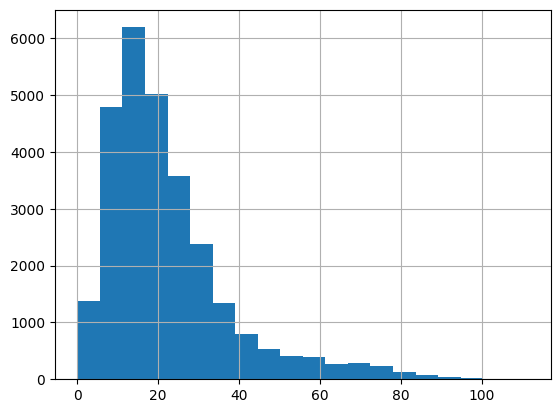

In [157]:
copa_america_events['pass_length'].hist(bins=20)

Discreticemos la varible *pass_length*, debido al ruido.

### Discretización de datos

In [158]:
copa_america_events['pass_length'] = pd.cut(copa_america_events['pass_length'], bins=3, labels=['short', 'medium', 'long'])

In [159]:
copa_america_events['pass_length'].value_counts()

,count
pass_length,
short,24312
medium,3143
long,418


### Agrupación y aplicación de funciones de agregación

In [160]:
def mode_series(series):
    if series.isnull().all():
        return np.nan

    values, counts = np.unique(series.dropna(), return_counts=True)
    index = np.argmax(counts)
    return values[index]

In [161]:
draft_model_df = copa_america_events.groupby(['player_id']).agg(
    sum_50_50_counterpress=('50_50_counterpress', 'sum'),
    sum_50_50_lost=('50_50_lost', 'sum'),
    sum_50_50_success_to_opposition=('50_50_success_to_opposition', 'sum'),
    sum_50_50_success_to_team=('50_50_success_to_team', 'sum'),
    sum_50_50_won=('50_50_won', 'sum'),
    sum_ball_recovery_offensive=('ball_recovery_offensive', 'sum'),
    sum_ball_recovery_offensive_success=('ball_recovery_offensive_success', 'sum'),
    sum_ball_recovery_recovery_failure=('ball_recovery_recovery_failure', 'sum'),
    sum_ball_receipt_outcome_incomplete=('ball_receipt_outcome_incomplete', 'sum'),
    sum_block_deflection=('block_deflection', 'sum'),
    sum_block_offensive=('block_offensive', 'sum'),
    sum_block_save_block=('block_save_block', 'sum'),
    sum_block=('block', 'sum'),
    sum_clearance_aerial_won=('clearance_aerial_won', 'sum'),
    count_clearance=('clearance_aerial_won', 'count'),
    count_clearance_body_part=('clearance_body_part', 'count'),
    sum_dribble_no_touch=('dribble_no_touch', 'sum'),
    sum_dribble_nutmeg=('dribble_nutmeg', 'sum'),
    sum_dribble_outcome_complete=('dribble_outcome_complete', 'sum'),
    sum_dribble_outcome_incomplete=('dribble_outcome_incomplete', 'sum'),
    sum_dribble_overrun=('dribble_overrun', 'sum'),
    sum_duel_counterpress=('duel_counterpress', 'sum'),
    sum_duel_outcome_lost_in_play=('duel_outcome_lost_in_play', 'sum'),
    sum_duel_outcome_lost_out=('duel_outcome_lost_out', 'sum'),
    sum_duel_outcome_success_in_play=('duel_outcome_success_in_play', 'sum'),
    sum_duel_outcome_success_out=('duel_outcome_success_out', 'sum'),
    sum_duel_outcome_won=('duel_outcome_won', 'sum'),
    mode_duel_type=('duel_type', mode_series),  # Por si se quiere contar
    sum_foul_committed_type_dangerous_play=('foul_committed_type_dangerous_play', 'sum'),
    sum_foul_committed_type_foul_out=('foul_committed_type_foul_out', 'sum'),
    sum_foul_committed_type_handball=('foul_committed_type_handball', 'sum'),
    sum_interception_outcome_lost_in_play=('interception_outcome_lost_in_play', 'sum'),
    sum_interception_outcome_lost_out=('interception_outcome_lost_out', 'sum'),
    sum_interception_outcome_success_in_play=('interception_outcome_success_in_play', 'sum'),
    sum_interception_outcome_success_out=('interception_outcome_success_out', 'sum'),
    sum_interception_outcome_won=('interception_outcome_won', 'sum'),
    sum_miscontrol_aerial_won=('miscontrol_aerial_won', 'sum'),
    mode_pass_body_part=('pass_body_part', mode_series),
    sum_pass_cross=('pass_cross', 'sum'),
    sum_pass_goal_assist=('pass_goal_assist', 'sum'),
    mode_pass_height=('pass_height', mode_series),
    mode_pass_length=('pass_length', mode_series),
    sum_pass_outcome_complete=('pass_outcome_complete', 'sum'),
    sum_pass_outcome_incomplete=('pass_outcome_incomplete', 'sum'),
    sum_pass_outcome_injury_clearance=('pass_outcome_injury_clearance', 'sum'),
    sum_pass_outcome_out=('pass_outcome_out', 'sum'),
    sum_pass_outcome_pass_offside=('pass_outcome_pass_offside', 'sum'),
    sum_pass_outcome_unknown=('pass_outcome_unknown', 'sum'),
    sum_pass_shot_assist=('pass_shot_assist', 'sum'),
    sum_pass_cross_complete=('pass_cross_complete', 'sum'),
    sum_pass_goal_assist_complete=('pass_goal_assist_complete', 'sum'),
    sum_pass_under_pressure_complete=('pass_under_pressure_complete', 'sum'),
    mode_pass_type=('pass_type', mode_series),  # Por si se quiere contar
    sum_pass_under_pressure=('pass_under_pressure', 'sum'),
    sum_pass_shot_assist_complete=('pass_shot_assist_complete', 'sum'),
    mode_position=('position', mode_series),  # Por si se quiere contar
    sum_shot_aerial_won=('shot_aerial_won', 'sum'),
    mode_shot_body_part=('shot_body_part', mode_series), # Saber con que pie tira
    sum_shot_first_time=('shot_first_time', 'sum'),
    sum_shot_open_goal=('shot_open_goal', 'sum'),
    sum_shot_outcome_blocked=('shot_outcome_blocked', 'sum'),
    sum_shot_outcome_goal=('shot_outcome_goal', 'sum'),
    sum_shot_outcome_off_t=('shot_outcome_off_t', 'sum'),
    sum_shot_outcome_post=('shot_outcome_post', 'sum'),
    sum_shot_outcome_saved=('shot_outcome_saved', 'sum'),
    sum_shot_outcome_saved_to_post=('shot_outcome_saved_to_post', 'sum'),
    sum_shot_outcome_wayward=('shot_outcome_wayward', 'sum'),
    mean_shot_statsbomb_xg=('shot_statsbomb_xg', 'mean'),
    mode_shot_technique=('shot_technique', mode_series),  # Por si se quiere contar
    mode_shot_type=('shot_type', mode_series),  # Por si se quiere contar
    sum_shot_under_pressure=('shot_under_pressure', 'sum'),
    sum_goal_first_time=('goal_first_time', 'sum'),
    sum_goal_aerial_won=('goal_aerial_won', 'sum'),
    sum_goal_open_goal=('goal_open_goal', 'sum'),
    sum_goal_under_pressure=('goal_under_pressure', 'sum')
)

In [162]:
draft_model_df.head()

,sum_50_50_counterpress,sum_50_50_lost,sum_50_50_success_to_opposition,sum_50_50_success_to_team,sum_50_50_won,sum_ball_recovery_offensive,sum_ball_recovery_offensive_success,sum_ball_recovery_recovery_failure,sum_ball_receipt_outcome_incomplete,sum_block_deflection,sum_block_offensive,sum_block_save_block,sum_block,sum_clearance_aerial_won,count_clearance,count_clearance_body_part,sum_dribble_no_touch,sum_dribble_nutmeg,sum_dribble_outcome_complete,sum_dribble_outcome_incomplete,sum_dribble_overrun,sum_duel_counterpress,sum_duel_outcome_lost_in_play,sum_duel_outcome_lost_out,sum_duel_outcome_success_in_play,sum_duel_outcome_success_out,sum_duel_outcome_won,mode_duel_type,sum_foul_committed_type_dangerous_play,sum_foul_committed_type_foul_out,sum_foul_committed_type_handball,sum_interception_outcome_lost_in_play,sum_interception_outcome_lost_out,sum_interception_outcome_success_in_play,sum_interception_outcome_success_out,sum_interception_outcome_won,sum_miscontrol_aerial_won,mode_pass_body_part,sum_pass_cross,sum_pass_goal_assist,mode_pass_height,mode_pass_length,sum_pass_outcome_complete,sum_pass_outcome_incomplete,sum_pass_outcome_injury_clearance,sum_pass_outcome_out,sum_pass_outcome_pass_offside,sum_pass_outcome_unknown,sum_pass_shot_assist,sum_pass_cross_complete,sum_pass_goal_assist_complete,sum_pass_under_pressure_complete,mode_pass_type,sum_pass_under_pressure,sum_pass_shot_assist_complete,mode_position,sum_shot_aerial_won,mode_shot_body_part,sum_shot_first_time,sum_shot_open_goal,sum_shot_outcome_blocked,sum_shot_outcome_goal,sum_shot_outcome_off_t,sum_shot_outcome_post,sum_shot_outcome_saved,sum_shot_outcome_saved_to_post,sum_shot_outcome_wayward,mean_shot_statsbomb_xg,mode_shot_technique,mode_shot_type,sum_shot_under_pressure,sum_goal_first_time,sum_goal_aerial_won,sum_goal_open_goal,sum_goal_under_pressure
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2995,0,0,0,0,0,0,0,0,43,0,0,0,0,False,1,1,0,3,8,10,3,2,1,1,2,0,0,Tackle,0,0,0,0,0,0,0,0,0,Left Foot,9,1,Ground Pass,short,132,36,0,3,1,2,10,5,1,0,Corner,6,10,Right Midfield,0,Left Foot,2,0,0,0,2,0,4,0,0,0.091971,Normal,Open Play,2,0,0,0,0
3063,1,2,1,0,0,1,1,0,4,0,0,0,0,1,14,14,0,0,2,0,0,2,1,0,3,0,1,Tackle,0,0,1,4,1,1,0,1,0,Right Foot,4,0,Ground Pass,short,216,40,0,1,0,1,4,2,0,0,Throw-in,10,4,Right Back,True,Head,False,False,0,0,0,0,0,0,1,0.076589,Normal,Open Play,1,0,0,0,0
3090,0,0,0,0,0,0,0,0,0,0,0,0,0,3,6,6,0,0,0,0,0,0,1,0,0,0,0,Aerial Lost,0,0,0,0,0,1,0,0,0,Right Foot,0,0,Ground Pass,short,92,6,0,0,0,0,0,0,0,0,Recovery,1,0,Left Center Back,0,Head,0,0,0,1,2,0,0,0,0,0.502356,Normal,Open Play,0,0,0,0,0
3159,0,2,0,0,0,0,0,0,7,1,0,0,1,2,5,5,0,0,0,0,0,0,2,2,0,1,0,Tackle,0,0,1,0,2,1,0,2,0,Left Foot,2,0,Ground Pass,short,46,18,0,1,0,2,1,1,0,0,Throw-in,2,1,Left Wing Back,0,NaN,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0
3312,0,0,0,0,1,0,0,1,17,0,1,0,1,False,1,1,0,0,2,2,0,0,0,1,0,0,0,Aerial Lost,0,0,0,0,1,1,0,1,0,Right Foot,2,0,Ground Pass,short,30,10,0,2,0,1,1,1,0,0,Corner,2,1,Left Wing,0,Right Foot,0,0,1,0,1,0,0,0,0,0.049376,Normal,Open Play,1,0,0,0,0


### Creación de columnas de proporción

In [163]:
draft_model_df['proportion_50_50_won'] = (draft_model_df[['sum_50_50_won', 'sum_50_50_success_to_team']].sum(axis=1) / draft_model_df[['sum_50_50_lost',	'sum_50_50_success_to_opposition',	'sum_50_50_success_to_team',	'sum_50_50_won']].sum(axis=1)).fillna(0)
draft_model_df['proportion_ball_recovery_offensive_success'] = (draft_model_df['sum_ball_recovery_offensive_success'] / draft_model_df['sum_ball_recovery_offensive']).fillna(0)
draft_model_df['proportion_save_block'] = (draft_model_df['sum_block_save_block'] / draft_model_df['sum_block']).fillna(0)
draft_model_df['proportion_block_deflection'] = (draft_model_df['sum_block_deflection'] / draft_model_df['sum_block']).fillna(0)
draft_model_df['proportion_clearance_aerial_won'] = (draft_model_df['sum_clearance_aerial_won'] / draft_model_df['count_clearance_body_part'].replace(0, np.nan)).fillna(0)
draft_model_df['proportion_dribble_complete'] = (draft_model_df['sum_dribble_outcome_complete'] / draft_model_df[['sum_dribble_outcome_complete', 'sum_dribble_outcome_incomplete']].sum(axis=1)).fillna(0)
draft_model_df['proportion_dribble_nutmeg'] = (draft_model_df['sum_dribble_nutmeg'] / draft_model_df[['sum_dribble_outcome_complete', 'sum_dribble_outcome_incomplete']].sum(axis=1).replace(0, np.nan)).fillna(0)
draft_model_df['proportion_dribble_overrun'] = (draft_model_df['sum_dribble_overrun'] / draft_model_df[['sum_dribble_outcome_complete', 'sum_dribble_outcome_incomplete']].sum(axis=1).replace(0, np.nan)).fillna(0)
draft_model_df['proportion_duel_won'] = (draft_model_df[['sum_duel_outcome_won']].sum(axis=1) / draft_model_df[['sum_duel_outcome_won', 'sum_duel_outcome_success_out', 'sum_duel_outcome_success_in_play', 'sum_duel_outcome_lost_out', 'sum_duel_outcome_lost_in_play']].sum(axis=1)).fillna(0)
draft_model_df['proportion_duel_success_in_play'] = (draft_model_df[['sum_duel_outcome_success_in_play']].sum(axis=1) / draft_model_df[['sum_duel_outcome_won', 'sum_duel_outcome_success_out', 'sum_duel_outcome_success_in_play', 'sum_duel_outcome_lost_out', 'sum_duel_outcome_lost_in_play']].sum(axis=1)).fillna(0)
draft_model_df['proportion_duel_success_out'] = (draft_model_df[['sum_duel_outcome_success_out']].sum(axis=1) / draft_model_df[['sum_duel_outcome_won', 'sum_duel_outcome_success_out', 'sum_duel_outcome_success_in_play', 'sum_duel_outcome_lost_out', 'sum_duel_outcome_lost_in_play']].sum(axis=1)).fillna(0)
draft_model_df['proportion_foul_dangerous_play'] = (draft_model_df['sum_foul_committed_type_dangerous_play'] / draft_model_df[['sum_foul_committed_type_dangerous_play', 'sum_foul_committed_type_foul_out', 'sum_foul_committed_type_handball']].sum(axis=1).replace(0, np.nan)).fillna(0)
draft_model_df['proportion_interception_won'] = (draft_model_df[['sum_interception_outcome_won']].sum(axis=1) / draft_model_df[['sum_interception_outcome_won', 'sum_interception_outcome_success_out', 'sum_interception_outcome_success_in_play', 'sum_interception_outcome_lost_out', 'sum_interception_outcome_lost_in_play']].sum(axis=1)).fillna(0)
draft_model_df['proportion_interception_success_in_play'] = (draft_model_df[['sum_interception_outcome_success_in_play']].sum(axis=1) / draft_model_df[['sum_interception_outcome_won', 'sum_interception_outcome_success_out', 'sum_interception_outcome_success_in_play', 'sum_interception_outcome_lost_out', 'sum_interception_outcome_lost_in_play']].sum(axis=1)).fillna(0)
draft_model_df['proportion_interception_success_out'] = (draft_model_df[['sum_interception_outcome_success_out']].sum(axis=1) / draft_model_df[['sum_interception_outcome_won', 'sum_interception_outcome_success_out', 'sum_interception_outcome_success_in_play', 'sum_interception_outcome_lost_out', 'sum_interception_outcome_lost_in_play']].sum(axis=1)).fillna(0)
draft_model_df['proportion_pass_cross'] = (draft_model_df['sum_pass_cross'] / draft_model_df[['sum_pass_outcome_complete', 'sum_pass_outcome_incomplete', 'sum_pass_outcome_injury_clearance', 'sum_pass_outcome_out', 'sum_pass_outcome_pass_offside', 'sum_pass_outcome_unknown']].sum(axis=1).replace(0, np.nan)).fillna(0)
draft_model_df['proportion_pass_goal_assist'] = (draft_model_df['sum_pass_goal_assist'] / draft_model_df[['sum_pass_outcome_complete', 'sum_pass_outcome_incomplete', 'sum_pass_outcome_injury_clearance', 'sum_pass_outcome_out', 'sum_pass_outcome_pass_offside', 'sum_pass_outcome_unknown']].sum(axis=1).replace(0, np.nan)).fillna(0)
draft_model_df['proportion_pass_shot_assist'] = (draft_model_df['sum_pass_shot_assist'] / draft_model_df[['sum_pass_outcome_complete', 'sum_pass_outcome_incomplete', 'sum_pass_outcome_injury_clearance', 'sum_pass_outcome_out', 'sum_pass_outcome_pass_offside', 'sum_pass_outcome_unknown']].sum(axis=1).replace(0, np.nan)).fillna(0)
draft_model_df['proportion_pass_cross_complete'] = (draft_model_df['sum_pass_cross_complete'] / draft_model_df['sum_pass_cross'].replace(0, np.nan)).fillna(0)
draft_model_df['proportion_pass_goal_assist_complete'] = (draft_model_df['sum_pass_goal_assist_complete'] / draft_model_df['sum_pass_goal_assist'].replace(0, np.nan)).fillna(0)
draft_model_df['proportion_pass_shot_assist_complete'] = (draft_model_df['sum_pass_shot_assist_complete'] / draft_model_df['sum_pass_shot_assist'].replace(0, np.nan)).fillna(0)
draft_model_df['proportion_pass_under_pressure_complete'] = (draft_model_df['sum_pass_under_pressure_complete'] / draft_model_df['sum_pass_under_pressure'].replace(0, np.nan)).fillna(0)
draft_model_df['proportion_shot_first_time'] = (draft_model_df['sum_shot_first_time'] / draft_model_df[['sum_shot_outcome_blocked', 'sum_shot_outcome_goal', 'sum_shot_outcome_off_t', 'sum_shot_outcome_post', 'sum_shot_outcome_saved', 'sum_shot_outcome_saved_to_post', 'sum_shot_outcome_wayward']].sum().replace(0, np.nan)).fillna(0)
draft_model_df['proportion_shot_aerial_won'] = (draft_model_df['sum_shot_aerial_won'] / draft_model_df[['sum_shot_outcome_blocked', 'sum_shot_outcome_goal', 'sum_shot_outcome_off_t', 'sum_shot_outcome_post', 'sum_shot_outcome_saved', 'sum_shot_outcome_saved_to_post', 'sum_shot_outcome_wayward']].sum().replace(0, np.nan)).fillna(0)
draft_model_df['proportion_shot_open_goal'] = (draft_model_df['sum_shot_open_goal'] / draft_model_df[['sum_shot_outcome_blocked', 'sum_shot_outcome_goal', 'sum_shot_outcome_off_t', 'sum_shot_outcome_post', 'sum_shot_outcome_saved', 'sum_shot_outcome_saved_to_post', 'sum_shot_outcome_wayward']].sum().replace(0, np.nan)).fillna(0)
draft_model_df['proportion_goal'] = (draft_model_df['sum_shot_outcome_goal'] / draft_model_df[['sum_shot_outcome_blocked', 'sum_shot_outcome_goal', 'sum_shot_outcome_off_t', 'sum_shot_outcome_post', 'sum_shot_outcome_saved', 'sum_shot_outcome_saved_to_post', 'sum_shot_outcome_wayward']].sum().replace(0, np.nan)).fillna(0)
draft_model_df['proportion_goal_shot_first_time'] = (draft_model_df['sum_goal_first_time'] / draft_model_df['sum_shot_first_time'].replace(0, np.nan)).fillna(0)
draft_model_df['proportion_goal_aerial_won'] = (draft_model_df['sum_goal_aerial_won'] / draft_model_df['sum_shot_aerial_won'].replace(0, np.nan)).fillna(0)
draft_model_df['proportion_goal_open_goal'] =  (draft_model_df['sum_goal_open_goal'] / draft_model_df['sum_shot_open_goal'].replace(0, np.nan)).fillna(0)
draft_model_df['proportion_goal_under_pressure'] = (draft_model_df['sum_goal_under_pressure'] / draft_model_df['sum_shot_under_pressure'].replace(0, np.nan)).fillna(0)

<ipython-input-163-a42ba2a7be5e>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  draft_model_df['proportion_clearance_aerial_won'] = (draft_model_df['sum_clearance_aerial_won'] / draft_model_df['count_clearance_body_part'].replace(0, np.nan)).fillna(0)
<ipython-input-163-a42ba2a7be5e>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  draft_model_df['proportion_dribble_nutmeg'] = (draft_model_df['sum_dribble_nutmeg'] / draft_model_df[['sum_dribble_outcome_complete', 'sum_dribble_outcome_incomplete']].sum(axis=1).replace(0, np.nan)).fillna(0)
<ipython-inpu

In [164]:
model_df = draft_model_df[[
    'mode_position',
    'proportion_50_50_won',
    'proportion_ball_recovery_offensive_success',
    'proportion_save_block',
    'proportion_block_deflection',
    'proportion_clearance_aerial_won',
    'proportion_dribble_complete',
    'proportion_dribble_nutmeg',
    'proportion_dribble_overrun',
    'proportion_duel_won',
    'proportion_duel_success_in_play',
    'proportion_duel_success_out',
    'mode_duel_type',
    'proportion_foul_dangerous_play',
    'proportion_interception_won',
    'proportion_interception_success_in_play',
    'proportion_interception_success_out',
    'proportion_pass_cross',
    'proportion_pass_goal_assist',
    'proportion_pass_shot_assist',
    'proportion_pass_cross_complete',
    'proportion_pass_goal_assist_complete',
    'proportion_pass_shot_assist_complete',
    'proportion_pass_under_pressure_complete',
    'mode_pass_body_part',
    'mode_pass_height',
    'mode_pass_length',
    'mode_pass_type',
    'proportion_shot_first_time',
    'proportion_shot_aerial_won',
    'proportion_shot_open_goal',
    'proportion_goal',
    'proportion_goal_shot_first_time',
    'proportion_goal_aerial_won',
    'proportion_goal_open_goal',
    'proportion_goal_under_pressure',
    'mode_shot_technique',
    'mode_shot_type',
    'mode_shot_body_part',
    'mean_shot_statsbomb_xg',
]]

### Codificar atributos nominales

In [165]:
model_df = pd.get_dummies(model_df, columns=[
    'mode_position',
    'mode_duel_type',
    'mode_pass_body_part',
    'mode_pass_height',
    'mode_pass_length',
    'mode_pass_type',
    'mode_shot_body_part',
    'mode_shot_technique',
    'mode_shot_type'
]).replace({True: 1, False: 0, np.nan: 0})

<ipython-input-165-e2e8d924f17b>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]).replace({True: 1, False: 0, np.nan: 0})


In [166]:
model_df.columns = model_df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

In [167]:
model_df.head()

,proportion_50_50_won,proportion_ball_recovery_offensive_success,proportion_save_block,proportion_block_deflection,proportion_clearance_aerial_won,proportion_dribble_complete,proportion_dribble_nutmeg,proportion_dribble_overrun,proportion_duel_won,proportion_duel_success_in_play,proportion_duel_success_out,proportion_foul_dangerous_play,proportion_interception_won,proportion_interception_success_in_play,proportion_interception_success_out,proportion_pass_cross,proportion_pass_goal_assist,proportion_pass_shot_assist,proportion_pass_cross_complete,proportion_pass_goal_assist_complete,proportion_pass_shot_assist_complete,proportion_pass_under_pressure_complete,proportion_shot_first_time,proportion_shot_aerial_won,proportion_shot_open_goal,proportion_goal,proportion_goal_shot_first_time,proportion_goal_aerial_won,proportion_goal_open_goal,proportion_goal_under_pressure,mean_shot_statsbomb_xg,mode_position_center_attacking_midfield,mode_position_center_back,mode_position_center_defensive_midfield,mode_position_center_forward,mode_position_goalkeeper,mode_position_left_back,mode_position_left_center_back,mode_position_left_center_forward,mode_position_left_center_midfield,mode_position_left_defensive_midfield,mode_position_left_midfield,mode_position_left_wing,mode_position_left_wing_back,mode_position_right_attacking_midfield,mode_position_right_back,mode_position_right_center_back,mode_position_right_center_forward,mode_position_right_center_midfield,mode_position_right_defensive_midfield,mode_position_right_midfield,mode_position_right_wing,mode_position_right_wing_back,mode_duel_type_aerial_lost,mode_duel_type_tackle,mode_pass_body_part_head,mode_pass_body_part_left_foot,mode_pass_body_part_no_touch,mode_pass_body_part_right_foot,mode_pass_height_ground_pass,mode_pass_height_high_pass,mode_pass_height_low_pass,mode_pass_length_short,mode_pass_length_medium,mode_pass_length_long,mode_pass_type_corner,mode_pass_type_free_kick,mode_pass_type_goal_kick,mode_pass_type_interception,mode_pass_type_kick_off,mode_pass_type_recovery,mode_pass_type_throw_in,mode_shot_body_part_head,mode_shot_body_part_left_foot,mode_shot_body_part_right_foot,mode_shot_technique_backheel,mode_shot_technique_diving_header,mode_shot_technique_half_volley,mode_shot_technique_lob,mode_shot_technique_normal,mode_shot_technique_volley,mode_shot_type_free_kick,mode_shot_type_open_play,mode_shot_type_penalty
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2995,0.0,0.0,0.0,0.0,0.000000,0.444444,0.166667,0.166667,0.0,0.5,0.0,0.0,0.000000,0.000000,0.0,0.051724,0.005747,0.057471,0.555556,1.0,1.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.091971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3063,0.0,1.0,0.0,0.0,0.071429,1.000000,0.000000,0.000000,0.2,0.6,0.0,0.0,0.142857,0.142857,0.0,0.015504,0.000000,0.015504,0.500000,0.0,1.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.076589,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
3090,0.0,0.0,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.502356,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
3159,0.0,0.0,0.0,1.0,0.400000,0.000000,0.000000,0.000000,0.0,0.0,0.2,0.0,0.400000,0.200000,0.0,0.029851,0.000000,0.014925,0.500000,0.0,1.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3312,1.0,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.046512,0.000000,0.023256,0.500000,0.0,1.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.049376,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0


Elijamos los atributos que nos permiten conocer la personalidad de juego de cada jugador.

In [168]:
clust_df = model_df[['proportion_50_50_won',
                     'proportion_save_block',
                     'proportion_block_deflection',
                     'proportion_clearance_aerial_won',
                     'proportion_dribble_complete',
                     'proportion_dribble_nutmeg',
                     'proportion_dribble_overrun',
                     'proportion_foul_dangerous_play',
                     'proportion_pass_cross',
                     'proportion_pass_goal_assist',
                     'proportion_pass_shot_assist',
                     'proportion_shot_first_time',
                     'proportion_shot_open_goal',
                     'proportion_goal',
                     'proportion_goal_under_pressure',
                     'mode_position_center_attacking_midfield',
                     'mode_position_center_back',
                     'mode_position_center_defensive_midfield',
                     'mode_position_center_forward',
                     'mode_position_left_center_back',
                     'mode_position_left_center_forward',
                     'mode_position_left_center_midfield',
                     'mode_position_left_defensive_midfield',
                     'mode_position_left_midfield',
                     'mode_position_left_wing',
                     'mode_position_left_wing_back',
                     'mode_position_right_attacking_midfield',
                     'mode_position_right_back',
                     'mode_position_right_center_back',
                     'mode_position_right_center_forward',
                     'mode_position_right_center_midfield',
                     'mode_position_right_defensive_midfield',
                     'mode_position_right_midfield',
                     'mode_position_right_midfield',
                     'mode_position_right_wing',
                     'mode_position_right_wing_back',
                     'mode_duel_type_aerial_lost',
                     'mode_duel_type_tackle',
                     'mode_pass_height_ground_pass',
                     'mode_pass_height_high_pass',
                     'mode_pass_height_low_pass',
                     'mode_pass_length_short',
                     'mode_pass_length_medium',
                     'mode_pass_length_long',
                     'mode_pass_type_corner',
                     'mode_pass_type_interception',
                     'mode_pass_type_recovery',
                     'mode_pass_type_throw_in',
                     'mode_shot_technique_backheel',
                     'mode_shot_technique_diving_header',
                     'mode_shot_technique_half_volley',
                     'mode_shot_technique_lob',
                     'mode_shot_technique_normal',
                     'mode_shot_technique_volley',
                     'mode_shot_type_free_kick',
                     'mode_shot_type_open_play',
                     'mode_shot_type_penalty']]

In [169]:
clust_df.head()

,proportion_50_50_won,proportion_save_block,proportion_block_deflection,proportion_clearance_aerial_won,proportion_dribble_complete,proportion_dribble_nutmeg,proportion_dribble_overrun,proportion_foul_dangerous_play,proportion_pass_cross,proportion_pass_goal_assist,proportion_pass_shot_assist,proportion_shot_first_time,proportion_shot_open_goal,proportion_goal,proportion_goal_under_pressure,mode_position_center_attacking_midfield,mode_position_center_back,mode_position_center_defensive_midfield,mode_position_center_forward,mode_position_left_center_back,mode_position_left_center_forward,mode_position_left_center_midfield,mode_position_left_defensive_midfield,mode_position_left_midfield,mode_position_left_wing,mode_position_left_wing_back,mode_position_right_attacking_midfield,mode_position_right_back,mode_position_right_center_back,mode_position_right_center_forward,mode_position_right_center_midfield,mode_position_right_defensive_midfield,mode_position_right_midfield,mode_position_right_midfield,mode_position_right_wing,mode_position_right_wing_back,mode_duel_type_aerial_lost,mode_duel_type_tackle,mode_pass_height_ground_pass,mode_pass_height_high_pass,mode_pass_height_low_pass,mode_pass_length_short,mode_pass_length_medium,mode_pass_length_long,mode_pass_type_corner,mode_pass_type_interception,mode_pass_type_recovery,mode_pass_type_throw_in,mode_shot_technique_backheel,mode_shot_technique_diving_header,mode_shot_technique_half_volley,mode_shot_technique_lob,mode_shot_technique_normal,mode_shot_technique_volley,mode_shot_type_free_kick,mode_shot_type_open_play,mode_shot_type_penalty
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2995,0.0,0.0,0.0,0.000000,0.444444,0.166667,0.166667,0.0,0.051724,0.005747,0.057471,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
3063,0.0,0.0,0.0,0.071429,1.000000,0.000000,0.000000,0.0,0.015504,0.000000,0.015504,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
3090,0.0,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3159,0.0,0.0,1.0,0.400000,0.000000,0.000000,0.000000,0.0,0.029851,0.000000,0.014925,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3312,1.0,0.0,0.0,0.000000,0.500000,0.000000,0.000000,0.0,0.046512,0.000000,0.023256,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [170]:
clust_df[clust_df.sum(axis=1) == 0]

,proportion_50_50_won,proportion_save_block,proportion_block_deflection,proportion_clearance_aerial_won,proportion_dribble_complete,proportion_dribble_nutmeg,proportion_dribble_overrun,proportion_foul_dangerous_play,proportion_pass_cross,proportion_pass_goal_assist,proportion_pass_shot_assist,proportion_shot_first_time,proportion_shot_open_goal,proportion_goal,proportion_goal_under_pressure,mode_position_center_attacking_midfield,mode_position_center_back,mode_position_center_defensive_midfield,mode_position_center_forward,mode_position_left_center_back,mode_position_left_center_forward,mode_position_left_center_midfield,mode_position_left_defensive_midfield,mode_position_left_midfield,mode_position_left_wing,mode_position_left_wing_back,mode_position_right_attacking_midfield,mode_position_right_back,mode_position_right_center_back,mode_position_right_center_forward,mode_position_right_center_midfield,mode_position_right_defensive_midfield,mode_position_right_midfield,mode_position_right_midfield,mode_position_right_wing,mode_position_right_wing_back,mode_duel_type_aerial_lost,mode_duel_type_tackle,mode_pass_height_ground_pass,mode_pass_height_high_pass,mode_pass_height_low_pass,mode_pass_length_short,mode_pass_length_medium,mode_pass_length_long,mode_pass_type_corner,mode_pass_type_interception,mode_pass_type_recovery,mode_pass_type_throw_in,mode_shot_technique_backheel,mode_shot_technique_diving_header,mode_shot_technique_half_volley,mode_shot_technique_lob,mode_shot_technique_normal,mode_shot_technique_volley,mode_shot_type_free_kick,mode_shot_type_open_play,mode_shot_type_penalty
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


No podemos analizar a los jugadores sin datos.

In [171]:
clust_df.drop(clust_df[clust_df.sum(axis=1) == 0].index, inplace=True)
clust_df.shape[0]

<ipython-input-171-7afde9df1cde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_df.drop(clust_df[clust_df.sum(axis=1) == 0].index, inplace=True)


339

Datos de los defensivos

In [172]:
clust_back_df = clust_df.loc[clust_df.loc[:, clust_df.columns.str.contains('back')].sum(axis=1) == 1, [
    'proportion_50_50_won',
    'proportion_save_block',
    'proportion_block_deflection',
    'proportion_clearance_aerial_won',
    'proportion_foul_dangerous_play',
    'proportion_pass_cross',
    'proportion_pass_goal_assist',
    'proportion_pass_shot_assist',
    'mode_duel_type_aerial_lost',
    'mode_duel_type_tackle',
    'mode_pass_height_ground_pass',
    'mode_pass_height_high_pass',
    'mode_pass_height_low_pass',
    'mode_pass_length_short',
    'mode_pass_length_medium',
    'mode_pass_length_long',
    'mode_pass_type_corner',
    'mode_pass_type_interception',
    'mode_pass_type_recovery',
    'mode_pass_type_throw_in'
]]

Datos de los medios

In [173]:
clust_midfield_df = clust_df.loc[clust_df.loc[:, clust_df.columns.str.contains('midfield')].sum(axis=1) == 1, ~clust_df.columns.str.contains('position')]

Datos de los delanteros

In [174]:
clust_forward_df = clust_df.loc[clust_df.loc[:, clust_df.columns.str.contains('forward')].sum(axis=1) == 1, ~clust_df.columns.str.contains('position')].drop(columns=[
    'proportion_save_block',
    'proportion_block_deflection',
    'proportion_clearance_aerial_won'
])

## Análisis exploratorio de datos
Se hará un análisis exploratorio enfocado la correlacion de los datos obtenidos para así poder determinar si es conveniente hacer una reducción de dimensionalidad. De ser conveniente, se utilizará el método PCA y se hará el cálculo de eigenvalores y eigenvectores correspondientes para determinar las dimensiones a eliminar.

Correlación

In [175]:
clust_df.corr()

,proportion_50_50_won,proportion_save_block,proportion_block_deflection,proportion_clearance_aerial_won,proportion_dribble_complete,proportion_dribble_nutmeg,proportion_dribble_overrun,proportion_foul_dangerous_play,proportion_pass_cross,proportion_pass_goal_assist,proportion_pass_shot_assist,proportion_shot_first_time,proportion_shot_open_goal,proportion_goal,proportion_goal_under_pressure,mode_position_center_attacking_midfield,mode_position_center_back,mode_position_center_defensive_midfield,mode_position_center_forward,mode_position_left_center_back,mode_position_left_center_forward,mode_position_left_center_midfield,mode_position_left_defensive_midfield,mode_position_left_midfield,mode_position_left_wing,mode_position_left_wing_back,mode_position_right_attacking_midfield,mode_position_right_back,mode_position_right_center_back,mode_position_right_center_forward,mode_position_right_center_midfield,mode_position_right_defensive_midfield,mode_position_right_midfield,mode_position_right_midfield,mode_position_right_wing,mode_position_right_wing_back,mode_duel_type_aerial_lost,mode_duel_type_tackle,mode_pass_height_ground_pass,mode_pass_height_high_pass,mode_pass_height_low_pass,mode_pass_length_short,mode_pass_length_medium,mode_pass_length_long,mode_pass_type_corner,mode_pass_type_interception,mode_pass_type_recovery,mode_pass_type_throw_in,mode_shot_technique_backheel,mode_shot_technique_diving_header,mode_shot_technique_half_volley,mode_shot_technique_lob,mode_shot_technique_normal,mode_shot_technique_volley,mode_shot_type_free_kick,mode_shot_type_open_play,mode_shot_type_penalty
proportion_50_50_won,1.000000,-0.039551,0.072492,0.090942,0.153030,0.064879,0.124545,0.076155,0.051323,0.046332,0.106341,NaN,NaN,NaN,-0.034607,0.070148,0.003537,-0.002410,-0.020087,-0.073872,-0.072383,0.020606,0.099655,0.004097,0.055665,-0.050635,-0.057884,0.071945,0.083934,-0.065065,-0.048442,0.012509,0.024547,0.024547,0.042825,-0.004113,0.056691,0.048897,0.057333,-0.033183,-0.051696,0.057884,-0.044703,-0.025733,0.025107,0.030167,0.108962,-0.015414,0.137264,-0.025733,-0.027191,-0.044703,0.209716,-0.051696,0.070443,0.191969,-0.063504
proportion_save_block,-0.039551,1.000000,-0.045072,0.011976,0.037183,-0.002353,-0.021868,-0.010481,0.008712,0.020308,-0.015409,NaN,NaN,NaN,-0.023398,-0.026326,-0.016423,-0.024433,-0.035264,0.054389,-0.022406,-0.024433,0.088162,-0.019021,-0.031442,-0.020206,-0.014970,0.189291,0.054389,-0.021331,-0.024433,-0.034524,-0.017766,-0.017766,-0.032232,-0.021331,-0.049545,0.084956,0.033009,-0.028973,-0.013370,0.014970,-0.011561,-0.006655,-0.031442,-0.013370,0.025554,0.074371,-0.006655,-0.006655,0.061635,0.249722,-0.035809,0.213246,0.188024,0.047520,-0.016423
proportion_block_deflection,0.072492,-0.045072,1.000000,0.064999,0.092890,-0.022787,0.035841,-0.031556,0.002719,-0.046985,-0.087732,NaN,NaN,NaN,0.000750,-0.079262,0.090242,-0.073563,-0.036956,0.129740,-0.015485,0.022352,-0.038560,-0.057270,-0.094665,0.168312,-0.045072,-0.005089,0.061709,-0.009794,0.022352,0.019386,0.011271,0.011271,-0.022276,-0.009794,-0.017481,0.126310,0.099383,-0.087232,-0.040253,0.045072,-0.034808,-0.020037,-0.094665,-0.040253,0.067729,0.113871,-0.020037,-0.020037,-0.065776,-0.034808,0.132639,-0.040253,-0.045072,0.105299,-0.049448
proportion_clearance_aerial_won,0.090942,0.011976,0.064999,1.000000,0.075581,0.094849,0.019807,-0.007490,-0.068891,0.177515,-0.009271,NaN,NaN,NaN,0.057105,0.107785,-0.008307,0.116359,-0.018174,0.136348,-0.093417,-0.101866,0.110237,-0.034129,-0.010661,0.003915,-0.062413,-0.008157,0.094768,-0.058537,-0.094724,-0.018597,-0.074071,-0.074071,-0.078710,0.055619,-0.023824,0.165351,0.109921,-0.089727,-0.055741,0.062413,-0.048201,-0.027746,-0.102641,0.113607,0.172126,0.024210,-0.027746,0.026445,-0.046475,0.054205,0.155158,-0.023988,-0.028282,0.121323,0.091017
proportion_dribble_complete,0.153030,0.037183,0.092890,0.075581,1.000000,0.128547,0.090557,0.012041,0.106044,-0.061827,0.086938,NaN,NaN,NaN,0.106735,0.008634,0.007649,0.079167,0.04

Claramente, no hay una fuerte correlación entre cada variable. Siendo la reduccion de dimensionalidad un método para eliminar redundancia entre variables, podemos concluir que no es conveniente aplicar reduccion de dimensionalidad, por lo tanto la clusterizacion será producida tomando las columnas originales.

Dicho lo anterior, teniendo un dataframe con 20 columnas, necesitaríamos una grafica en 20 dimensiones para poder visualizar los clusters. Siendo esto físicamente imposible, visualizaremos utilizando solamente las listas de pertenencia.

## Minería de datos: clusterización
Modelado por Clustering Jerárquico con Método de Ward

---



### Defensas:

In [176]:
# Aplicar clustering jerárquico con el método de Ward
Z = linkage(clust_back_df, method='ward')

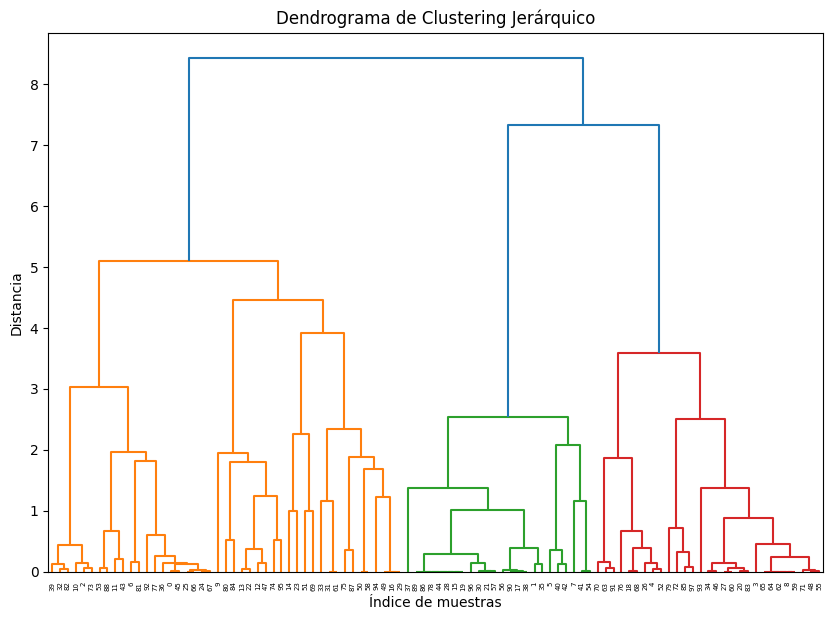

In [177]:
# Graficar el dendrograma
plt.figure(figsize=(10, 7))
plt.title("Dendrograma de Clustering Jerárquico")
dendrogram(Z)
plt.xlabel("Índice de muestras")
plt.ylabel("Distancia")
plt.show()

In [178]:
# Cortar el dendrograma para obtener 7 clusters (Numero obtenido visualmente)
labels_def = fcluster(Z, t=7, criterion='maxclust')

#labels_def = [s.replace(" ", ",") for s in labels_def]

# Mostrar los clusters asignados
print(labels_def)

[1 5 1 7 6 5 1 5 7 2 1 1 2 2 3 5 4 5 6 5 7 5 2 3 1 1 6 7 5 4 5 4 1 4 7 5 1
 5 5 1 5 5 5 1 5 1 7 2 7 4 4 3 6 1 5 7 5 5 4 7 7 4 7 6 7 7 1 1 6 3 6 7 7 1
 2 4 6 1 5 7 2 1 1 7 2 7 5 4 1 5 5 6 1 7 4 2 5 7]


### Medios:

In [179]:
# Aplicar clustering jerárquico con el método de Ward
Z = linkage(clust_midfield_df, method='ward')

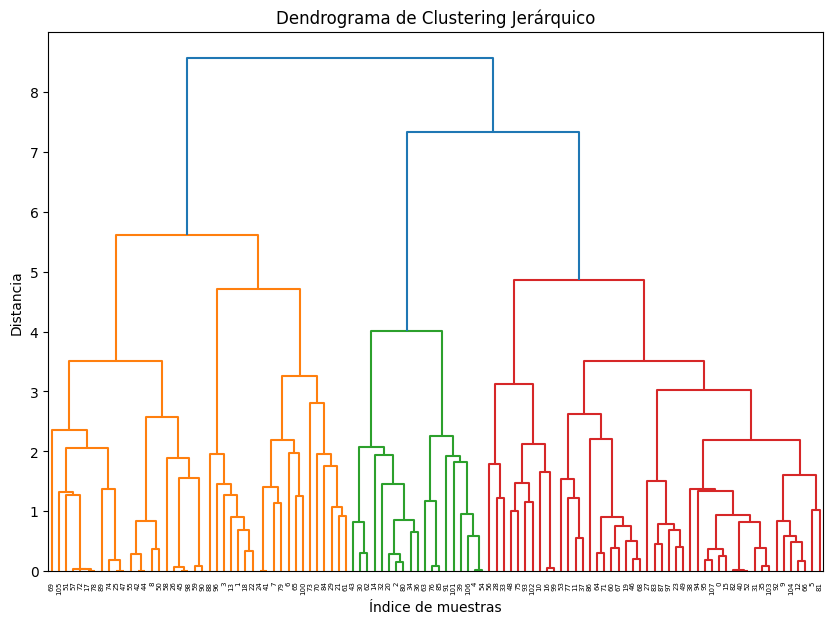

In [180]:
# Graficar el dendrograma
plt.figure(figsize=(10, 7))
plt.title("Dendrograma de Clustering Jerárquico")
dendrogram(Z)
plt.xlabel("Índice de muestras")
plt.ylabel("Distancia")
plt.show()

In [181]:
# Cortar el dendrograma para obtener 10 clusters (Numero obtenido visualmente)
labels_mid = fcluster(Z, t=10, criterion='maxclust')

labels_mid = labels_mid + 7
# Mostrar los clusters asignados
print(labels_mid)

[17 10 13 10 14 17 11 11  9 17 15 16 17 10 13 17 15  8 10 16 13 12 10 17
 11  8  9 17 15 12 13 17 13 15 13 17 13 16 17 14 17 11  9 13  9  9 16  8
 15 17  9  8 17 16 14  9 15  8  9  9 16 12 13 14 16 11 17 16 16  8 12 16
  8 12  8 15 14 16  8 11 13 17 17 17 12 14 16 17 10  8  9 14 17 15 17 17
 10 17  9 15 11 14 15 17 17  8 14 17]


### Delanteros:

In [182]:
# Aplicar clustering jerárquico con el método de Ward
Z = linkage(clust_forward_df, method='ward')

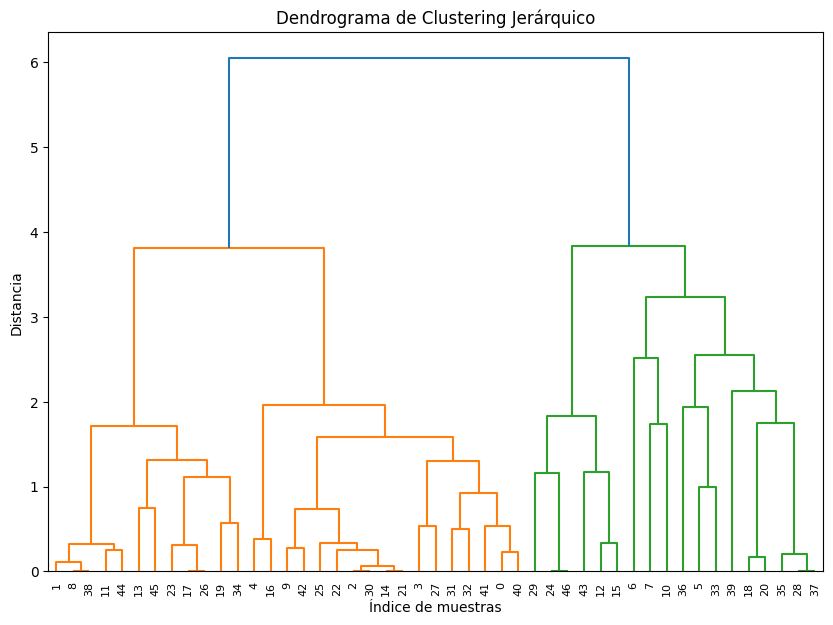

In [183]:
# Graficar el dendrograma
plt.figure(figsize=(10, 7))
plt.title("Dendrograma de Clustering Jerárquico")
dendrogram(Z)
plt.xlabel("Índice de muestras")
plt.ylabel("Distancia")
plt.show()

In [184]:
# Cortar el dendrograma para obtener 8 clusters (Numero obtenido visualmente)
labels_forw = fcluster(Z, t=6, criterion='maxclust')

labels_forw = labels_forw + 17

# Mostrar los clusters asignados
print(labels_forw)

[19 18 19 19 19 22 21 21 18 19 21 18 20 18 19 20 19 18 23 18 23 19 19 18
 20 19 18 19 23 20 19 19 19 22 18 23 22 23 18 23 19 19 19 20 18 18 20]


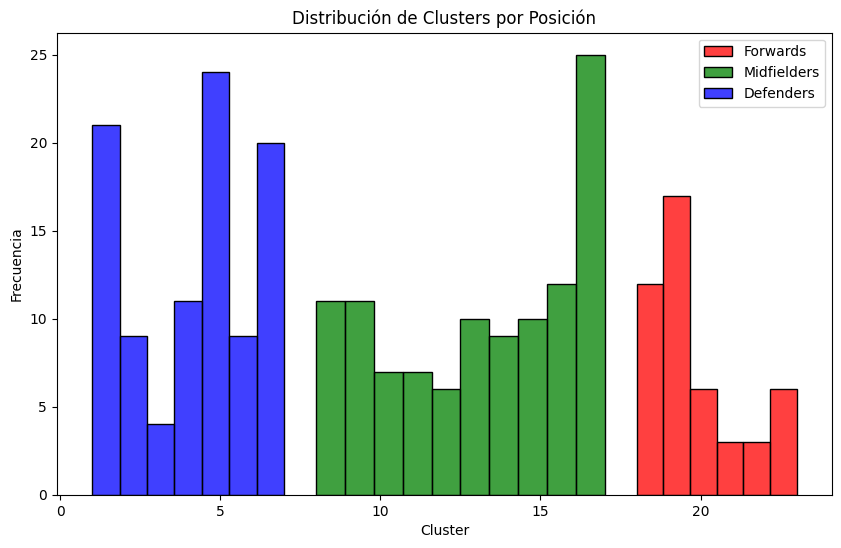

In [185]:
# Crear histograma de todas las categorias
plt.figure(figsize=(10, 6))
sns.histplot(labels_forw, bins=6, color='red', label='Forwards', kde=False)
sns.histplot(labels_mid, bins=10, color='green', label='Midfielders', kde=False)
sns.histplot(labels_def, bins=7, color='blue', label='Defenders', kde=False)
plt.title('Distribución de Clusters por Posición')
plt.xlabel('Cluster')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


## Integración de datos
A continuación, integraremos las categorías de las 'personalidades' de los jugadores a los dataframes originales. Con esto, contaremos la cantidad de personalidades por lineup de equipo.


In [186]:
# Ya que ambos conjuntos estan ordenados congruentemente, podemos asignar las columnas directamente
clust_back_df['category'] = labels_def
clust_midfield_df['category'] = labels_mid
clust_forward_df['category'] = labels_forw

In [187]:
# Extraer solo las etiquetas y ids
clust_back_df = clust_back_df.reset_index()[['player_id', 'category']]
clust_midfield_df = clust_midfield_df.reset_index()[['player_id', 'category']]
clust_forward_df = clust_forward_df.reset_index()[['player_id', 'category']]

In [188]:
# Juntarlos a una sola tabla
clusts_total = pd.concat([clust_back_df, clust_midfield_df, clust_forward_df])

## Preprocesamiento para modelo predictivo



In [189]:
# Cargamos los eventos de nuevo para obtener los datos omitidos previamente
copa_america_events = sb.events(match_id = copa_america_matches["match_id"][0])
for m in copa_america_matches["match_id"][1::]:
  copa_america_events = pd.concat([copa_america_events, sb.events(match_id = m)])
  for key in sb.lineups(match_id = m).keys():
      copa_america_lineups = pd.concat([copa_america_lineups, pd.DataFrame(sb.lineups(match_id = m)[key])])

/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: 

### Funciones para preprocesamiento de datos

In [190]:
# Tomar goles y cambios por minuto
goals = copa_america_events[copa_america_events['shot_outcome'] == 'Goal']
changes_per_minute = copa_america_events[copa_america_events['substitution_outcome_id'].notna()]
changes_per_minute = changes_per_minute.sort_values(by='minute', ascending= True)

In [191]:
# Hacer funcion para obtener lineup inicial
def get_starting_11(match_id):
  match_data = copa_america_events[copa_america_events['match_id'] == match_id]
  start_tactics = match_data[match_data['type'] == 'Starting XI']['tactics']

  lineup_home = pd.json_normalize(start_tactics.iloc[0])
  lineup_home = pd.json_normalize(lineup_home['lineup'])
  lineup_home = pd.json_normalize(lineup_home.iloc[0])
  lineup_home = lineup_home['player.id']

  lineup_away = pd.json_normalize(start_tactics.iloc[1])
  lineup_away = pd.json_normalize(lineup_away['lineup'])
  lineup_away = pd.json_normalize(lineup_away.iloc[0])
  lineup_away = lineup_away['player.id']

  lineup_home = list(lineup_home)
  lineup_away = list(lineup_away)

  # Eliminar a los porteros
  lineup_home.pop(0)
  lineup_away.pop(0)

  lineup_home = np.array(lineup_home)
  lineup_away = np.array(lineup_away)

  return lineup_home, lineup_away

In [192]:
def goals_per_lineup(match_id):
    lineups_per_change = []
    goals_per_change = []  # Lista adicional para almacenar solo los goles por cambio

    for i in range(2):
        # Selecciona el equipo actual basado en `i`
        current_team_id = changes_per_minute[changes_per_minute['match_id'] == match_id]['team_id'].unique()[i]
        lineups_updateable = []
        goal_counter = 0

        # Obtén alineaciones iniciales
        lineup_home, lineup_away = get_starting_11(match_id)
        if i == 0:
            current_team_lineup = list(lineup_home)
            opponent_team_lineup = list(lineup_away)
        else:
            current_team_lineup = list(lineup_away)
            opponent_team_lineup = list(lineup_home)

        # Configuración inicial de las alineaciones
        lineups_updateable = [current_team_lineup.copy(), opponent_team_lineup.copy()]

        # Filtrar goles del equipo actual en el partido
        match_goals = goals[(goals['match_id'] == match_id) & (goals['team_id'] == current_team_id)]

        # Obtener la lista de cambios por minuto para el partido actual
        changes = changes_per_minute[changes_per_minute['match_id'] == match_id]

        # Iterar sobre cada cambio y actualizar alineación y goles
        for index, row in changes.iterrows():
            # Definir minuto del cambio actual y el siguiente cambio (si existe)
            current_minute = row['minute']
            next_minute = changes.iloc[index + 1]['minute'] if index + 1 < len(changes) else float('inf')

            # Filtrar goles anotados entre el cambio actual y el siguiente
            goals_in_current_interval = match_goals[(match_goals['minute'] >= current_minute) & (match_goals['minute'] < next_minute)]

            # Agregar las alineaciones y el contador de goles actual al cambio
            lineups_per_change.append(lineups_updateable.copy())
            goals_per_change.append(len(goals_in_current_interval))

            # Revisa si el jugador que se quiere cambiar esta en algun lineup
            if row['player_id'] in current_team_lineup or row['player_id'] in opponent_team_lineup:
                # Actualiza alineación según el cambio
                if current_team_id == row['team_id']:
                    # Verificar de nuevo si el jugador está en el equipo actual antes de eliminarlo (colapsa sin esta condicion)
                    if row['player_id'] in current_team_lineup:
                        current_team_lineup.remove(row['player_id'])
                        current_team_lineup.append(row['substitution_replacement_id'])
                else:
                    # Verificar de nuevo si el jugador está en el equipo oponente antes de eliminarlo (colapsa sin esta condicion)
                    if row['player_id'] in opponent_team_lineup:
                        opponent_team_lineup.remove(row['player_id'])
                        opponent_team_lineup.append(row['substitution_replacement_id'])

                # Actualiza `lineups_updateable` con las nuevas alineaciones
                lineups_updateable = [current_team_lineup.copy(), opponent_team_lineup.copy()]

    return lineups_per_change, goals_per_change


### Obtener tensores para modelo de prediccion

Haremos una funcion para obtener todos los lineups en un tensor de la forma:

[[[equipo_propio1], [equipo_oponente1]], [[equipo_propio2], [equipo_oponente2]], ...]

Estos después serán reordenados dependiendo de las necesidades de cada modelo en especifico.

In [193]:
# Tomar todos los lineups de todos los partidos en todo momento
all_matches_lineups = []
all_matches_goals = []

# Variable para alternar entre tomar o ignorar filas
take_row = True

for index, row in copa_america_matches.iterrows():
    if take_row: # Tomamos en cuenta solo los matches del local, ya que la funcion previa toma en cuenta los dos lineups
        # Procesa la fila actual solo si `take_row` es True
        cur_match_lineups, cur_match_goals = goals_per_lineup(row['match_id'])
        for i in range(len(cur_match_lineups)):
            all_matches_lineups.append(cur_match_lineups[i])
            all_matches_goals.append(cur_match_goals[i])
    # Cambia el estado de `take_row` en cada iteración
    take_row = not take_row

In [194]:
# Estando alineadas las alineaciones con los goles, corroboramos que sean de la misma longitud
len(all_matches_lineups), len(all_matches_goals)

(310, 310)

In [195]:
# Substituimos a los ids de jugados con su respectiva categoría
def substitute_ids(clusts_total, all_matches_lineups):
  for index, rows in clusts_total.iterrows():
    for i in range(len(all_matches_lineups)):
      for j in range(2):
        for k in range(10):
          if rows['player_id'] == all_matches_lineups[i][j][k]:
            all_matches_lineups[i][j][k] = rows['category']

  # Imputacion de datos faltantes utilizando método probabilistico
  cats = clusts_total['category'].value_counts().sum()
  cat_probs = clusts_total['category'].value_counts()/cats
  cat_probs = cat_probs.reset_index()
  for i in range(len(all_matches_lineups)):
      for j in range(2):
        for k in range(10):
          if all_matches_lineups[i][j][k] > 25:
            all_matches_lineups[i][j][k] = np.random.choice(cat_probs['category'], p=cat_probs['count'])

  all_matches_lineups = np.array(all_matches_lineups)
  return all_matches_lineups

all_matches_lineups = substitute_ids(clusts_total, all_matches_lineups)
all_matches_goals = np.array(all_matches_goals)

## Experimentos de modelos predictivos

A continuación, vamos a experimentar con diferentes modelos de prediccion para ve cual resulta en el menor error promedio. Estos fueron seleccionados ya que, dada una investigación exhaustiva, se consideraron útiles para este caso de uso.

### Modelo de regresion lineal bayesiana

In [196]:
# Separar datos de entrada (X) y salida (y)
X_train = all_matches_lineups[:int(0.8*len(all_matches_lineups))]
y_train = all_matches_goals[:int(0.8*len(all_matches_goals))]
X_test = all_matches_lineups[int(0.8*len(all_matches_lineups)):]
y_test = all_matches_goals[int(0.8*len(all_matches_goals)):]

# Aplanar
X_train = np.array(X_train).reshape(len(X_train), -1)
X_test = np.array(X_test).reshape(len(X_test), -1)

# Crear y entrenar el modelo de regresión lineal bayesiana
model_bayes = BayesianRidge()
model_bayes.fit(X_train, y_train)

BayesianRidge()

In [197]:
# Hacer predicciones
y_preds = model_bayes.predict(X_test)

# Evaluar las predicciones con error promedio
mae_regresion = mean_absolute_error(y_test, y_preds)
mae_regresion

0.6521881732207236

### Modelo de Suport Vector machine

In [198]:
# Aplanar X para convertirlo en (248, 20)
X_flattened = all_matches_lineups.reshape(all_matches_lineups.shape[0], -1)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train = X_flattened[:int(0.8*len(X_flattened))]
y_train = all_matches_goals[:int(0.8*len(all_matches_goals))]
X_test = X_flattened[int(0.8*len(X_flattened)):]
y_test = all_matches_goals[int(0.8*len(all_matches_goals)):]

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo SVM para regresión
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Puedes ajustar estos parámetros

# Ajustar el modelo
svm_model.fit(X_train_scaled, y_train)

SVR()

In [199]:
# Hacer predicciones
y_pred = svm_model.predict(X_test_scaled)

# Evaluar el modelo
mae_svm = mean_absolute_error(y_test, y_pred)
mae_svm

0.44126738647984887

### Modelo de capas densas

In [200]:
X_train = all_matches_lineups[:int(0.8*len(all_matches_lineups))]
y_train = all_matches_goals[:int(0.8*len(all_matches_goals))]
X_test = all_matches_lineups[int(0.8*len(all_matches_lineups)):]
y_test = all_matches_goals[int(0.8*len(all_matches_goals)):]

In [201]:
X_train.shape

(248, 2, 10)

In [202]:
# Aplanar en la entrada
inputs = layers.Input(shape=(2, 10))

# Aplanar el tensor
x = layers.Flatten()(inputs)

# Capas densas
x = layers.Dense(124, activation='relu')(x)
x = layers.Dropout(rate = 0.2)(x) # Reducir overfitting
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(rate = 0.2)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(rate = 0.2)(x)
x = layers.Dense(124, activation='relu')(x)
x = layers.Dropout(rate = 0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(rate = 0.2)(x)
x = layers.Dense(32, activation = 'relu')(x)

# Salida
output = layers.Dense(1)(x)

# Crear modelo
model_dense = tf.keras.Model(inputs=inputs, outputs=output)

# Compilar
model_dense.compile(loss='mae', optimizer='adam')

# Ajustar el modelo
model_dense.fit(X_train, y_train, epochs=60, batch_size=128, validation_data=(X_test, y_test), verbose = 0)

In [203]:
# Calculamos error promedio
y_preds = model_dense.predict(X_test)

mae_dense = mean_absolute_error(y_test, y_preds)
mae_dense

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


0.32868271273365546

Después de la serie de experimentos, podemos ver que de los modelos utilizados el de mejor rendimiento es un modelo simple de capas densas.

## Predecir sobre un partido real

In [205]:
# Funcion para predecir un solo partido
def pred_and_print(partido):
  y_pred = model_dense.predict(partido)
  return y_pred

In [206]:
copa_america_matches.tail()

,match_id,home_team,away_team,home_score,away_score,competition_stage
27,3939974,United States,Bolivia,2,0,Group Stage
28,3939972,Ecuador,Venezuela,1,2,Group Stage
29,3939971,Mexico,Jamaica,1,0,Group Stage
30,3939970,Peru,Chile,0,0,Group Stage
31,3939969,Argentina,Canada,2,0,Group Stage


Tomemos el juego México-Jamaica ya que, estando cerca del final del dataframe, es un dato que el modelo nunca ha visto y por lo tanto dará una prediccion generalizada.

In [207]:
mexico_11, jamaica_11 = get_starting_11(3939971)

# Adaptamos la funcion previa para un solo partido
def substitute_ids_single_match(clust_total, all_matches_lineups):
  for index, rows in clusts_total.iterrows():
      for i in range(2):
          for j in range(10):
              if rows['player_id'] == all_matches_lineups[i][j]:
                  all_matches_lineups[i][j] = rows['category']

  # Imputación de datos faltantes utilizando método probabilístico
  cats = clusts_total['category'].value_counts().sum()
  cat_probs = clusts_total['category'].value_counts() / cats
  cat_probs = cat_probs.reset_index()
  for i in range(2):
      for j in range(10):
          if all_matches_lineups[i][j] > 25:
              all_matches_lineups[i][j] = np.random.choice(cat_probs['category'], p=cat_probs['count'])

  all_matches_lineups = np.array(all_matches_lineups)


  all_matches_lineups = all_matches_lineups.reshape(1, all_matches_lineups.shape[0], all_matches_lineups.shape[1])

  return all_matches_lineups

mexico_v_jamaica = substitute_ids_single_match(clusts_total, [mexico_11, jamaica_11])
jamaica_v_mexico = substitute_ids_single_match(clusts_total, [jamaica_11, mexico_11])

In [208]:
mexico_v_jamaica

array([[[ 1,  5,  5, 18, 11, 14, 14,  6, 13, 19],
        [ 7,  5,  5,  1,  1, 12, 10, 18,  4, 19]]])

In [209]:
goles_mexico = pred_and_print(mexico_v_jamaica)
goles_jamaica = pred_and_print(jamaica_v_mexico)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [210]:
print(f"La diferencia de goles esperados a favor de méxico es: {goles_mexico[0][0] - goles_jamaica[0][0]}")

La diferencia de goles esperados a favor de méxico es: -0.5165152549743652


**Nota:** Esta prediccion en especifico solo toma en cuenta el lineup inicial. Manteniendose congruente con el caso de uso intencionado.

Ahora vamos a hacer la misma prediccion con la alineacion que metió el gol durante ese partido.

In [211]:
# Visualizamos goles
all_matches_goals

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [212]:
# Parece ser que la alineacion de méxico que metió el gol esta en el índice -41, vamos a visualizarla
all_matches_lineups[-41][0]

array([ 3,  7,  6, 12,  8,  7, 16, 19,  8, 16])

In [213]:
mexico_v_jamaica[0][0] = all_matches_lineups[-41][0]
mexico_v_jamaica[0][1] = all_matches_lineups[-41][1]
jamaica_v_mexico[0][0] = all_matches_lineups[-41][1]
jamaica_v_mexico[0][1] = all_matches_lineups[-41][0]

In [214]:
# Ahora vamos a hacer la prediccion con esa alineación
goles_mexico = pred_and_print(mexico_v_jamaica)
goles_jamaica = pred_and_print(jamaica_v_mexico)
print(f"La diferencia de goles esperados a favor de méxico es: {goles_mexico[0][0] - goles_jamaica[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
La diferencia de goles esperados a favor de méxico es: 0.3279586732387543


Ventaja del partido a favor de México.

## Optimizacion del lineup

Para poder recomendar un cambio que mejore la alineacion propia dada una alineación fija del oponente. Planeamos abordarlo como un problema de optimizacion combinatoria. Problema para el cual buscamos implementar una heurística voraz que tendrá como salida el mejor cambio dentro de la vecindad inmediata de soluciones factibles.

Tomaremos el mismo ejemplo del partido México contra Jamaica.

In [228]:
def calculate_changes(lineups):
  # Declarar el primer lineup como el mejor
  first_lineup = np.copy(lineups[0][0])
  best_lineup = first_lineup
  first_pred = model_dense.predict(lineups)  # Predicción inicial
  best_pred = first_pred

  for i in range(10):
      for j in range(23):
          temp_lineup = np.copy(first_lineup)
          temp_lineup[i] = temp_lineup[i] - 23 if temp_lineup[i] > 23 else temp_lineup[i] + 1

          lineups[0][0] = temp_lineup
          cur_pred = model_dense.predict(lineups)

          if cur_pred > best_pred:
              best_pred = cur_pred
              best_lineup = np.copy(temp_lineup)  # Actualizar el mejor lineup encontrado

      # Restaurar el lineup original después de cada iteración de j
      lineups[0][0] = first_lineup

  # Resultado
  for i in range(10):
    if first_lineup[i] != best_lineup[i]:
      print(f"Se recomienda cambiar a un jugador de la clase: {first_lineup[i]}\nPor un jugador de la clase: {best_lineup[i]}\nIncremento de goles esperados: {best_pred - first_pred}")


In [229]:
# Ponemos a prueba la funcion para el partido de México contra Jamaica
calculate_changes(mexico_v_jamaica)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

## Conclusión

En este notebook desarrollamos un método innovador para resolver el problema de optimizacion de alineaciones. El enfoque que se dio para resolver este problema fue el siguiente:
* Clasificar a jugadores en base a su personalidad de juego
* Tomar en cuenta estas personalidades para calcular una esperanza de goles por equipo
* Tomar en cuenta estas esperanzas para optimizar al siguiente cambio de la alineación del equipo propio.

Posibles mejoras en el futuro:

Posterior a haber desarrollado este proyecto, podemos ver ciertas áreas de oportunidad que, de continuar este proyecto, pueden hacer de estas predicciones más acertadas y confiables. Haciendo su uso en equipos de alto rendimiento extremadamente útil y viable. Unas de las cuales son:
* Mayor disponibilidad de los eventos de los jugadores para no depender en metodos probabilísticos de imputacion de datos faltantes.
* Optimizacion de código para decrementar tiempo de ejecución y haciendo más viable utilizar esta herramienta en cualquier momento previo o durante un partido.
* Implementación de metaheurística de búsqueda tabú para optimizar alineaciones completas.
* Implementacion del modelo de rating de jugadores en específico para pesar el rendimiento del jugador en la toma de decisiones.

Sin más, agradecemos al lector por su tiempo.